
1. WCZYTANIE I PODSTAWOWA EKSPLORACJA DANYCH
--------------------------------------------------

📊 Podstawowe informacje o datasecie:
   • Liczba rekordów: 16,598
   • Liczba kolumn: 11
   • Rozmiar w pamięci: 4.74 MB


2. ANALIZA JAKOŚCI DANYCH
--------------------------------------------------

🔍 Analiza braków danych:
  Kolumna  Liczba braków  Procent braków
     Year            271        1.632727
Publisher             58        0.349440

🔄 Analiza duplikatów:
   • Kompletne duplikaty: 0
   • Gry występujące na wielu platformach: 2775

📏 Analiza zakresów danych:
   • Lata: 1980 - 2020 (brak danych: 271)
   • Sprzedaż globalna: 0.01M - 82.74M
   • Niespójności w sumowaniu sprzedaży: 2625


3. ANALIZA ROZKŁADÓW I OUTLIERÓW
--------------------------------------------------

🎯 Analiza outlierów - Global_Sales:
   • Q1: 0.06M
   • Q3: 0.47M
   • IQR: 0.41M
   • Granice outlierów: -0.55M - 1.08M
   • Liczba outlierów: 1,893 (11.4%)

🏆 Top 5 outlierów (największa sprzedaż):
   1. Wii Sp

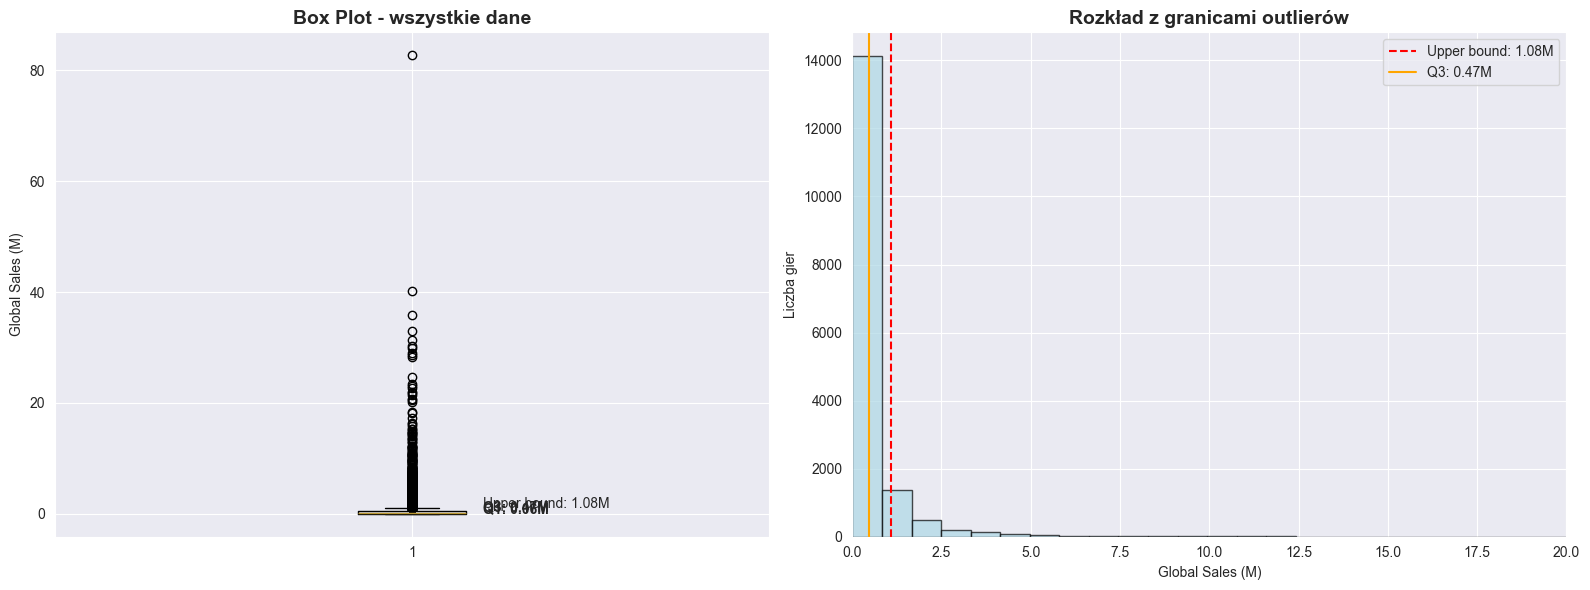


📊 Analiza percentyli dla lepszego zrozumienia:
   • 90 percentyl: 1.21M (1651 gier (9.9%) powyżej)
   • 95 percentyl: 2.04M (829 gier (5.0%) powyżej)
   • 99 percentyl: 5.43M (166 gier (1.0%) powyżej)
   • 99.5 percentyl: 8.11M (83 gier (0.5%) powyżej)
   • 99.9 percentyl: 21.05M (17 gier (0.1%) powyżej)

🎯 WNIOSKI dla granic outlierów:
   • Obecna granica (Q3 + 1.5*IQR): 1.08M
   • 95 percentyl: 2.04M
   • 99 percentyl: 5.43M
   • Można rozważyć zmianę granic na 95-99 percentyl zamiast standardowego 1.5*IQR


In [5]:
#!/usr/bin/env python
# coding: utf-8

"""
Big Data - Projekt: Ewolucja Globalnego Rynku Gier Wideo
Część 2: Zaawansowana Analiza - PCA, Clustering, Wizualizacje
Wersja zoptymalizowana - bazująca na oryginalnym kodzie
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from scipy import stats
from scipy.cluster.hierarchy import linkage, fcluster
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

# ========================================
# KONFIGURACJA - KONTROLA WYDRUKÓW
# ========================================
VERBOSE = False  # Ustaw True dla szczegółowych wydruków
SAVE_PLOTS = True
QUICK_MODE = True  # Pomija czasochłonne analizy podczas testowania

# Ustawienia wizualizacji
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

# ========================================
# 1. WCZYTANIE I PODSTAWOWA EKSPLORACJA DANYCH
# ========================================

print("\n1. WCZYTANIE I PODSTAWOWA EKSPLORACJA DANYCH")
print("-" * 50)

# Wczytanie danych
df = pd.read_csv('video games sales.csv')

print(f"\n📊 Podstawowe informacje o datasecie:")
print(f"   • Liczba rekordów: {len(df):,}")
print(f"   • Liczba kolumn: {len(df.columns)}")
print(f"   • Rozmiar w pamięci: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

if VERBOSE:
    print("\n📋 Struktura danych:")
    print(df.info())
    print("\n🔍 Pierwsze 5 rekordów:")
    print(df.head())
    print("\n📈 Podstawowe statystyki opisowe:")
    print(df.describe())

# ========================================
# 2. ANALIZA JAKOŚCI DANYCH
# ========================================

print("\n\n2. ANALIZA JAKOŚCI DANYCH")
print("-" * 50)

# Sprawdzenie braków danych
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

print("\n🔍 Analiza braków danych:")
missing_df = pd.DataFrame({
    'Kolumna': missing_data.index,
    'Liczba braków': missing_data.values,
    'Procent braków': missing_percent.values
})

# Tylko kolumny z brakami
missing_with_nulls = missing_df[missing_df['Liczba braków'] > 0]
if len(missing_with_nulls) > 0:
    print(missing_with_nulls.to_string(index=False))
else:
    print("   ✓ Brak danych brakujących")

# Sprawdzenie duplikatów
duplicates = df.duplicated().sum()
print(f"\n🔄 Analiza duplikatów:")
print(f"   • Kompletne duplikaty: {duplicates}")

if VERBOSE and duplicates > 0:
    print("   • Przykłady duplikatów:")
    print(df[df.duplicated()].head())

# Duplikaty nazw gier
name_duplicates = df.groupby('Name').size()
games_with_multiple_platforms = name_duplicates[name_duplicates > 1]
print(f"   • Gry występujące na wielu platformach: {len(games_with_multiple_platforms)}")

if VERBOSE:
    print("\n   Top gry multi-platform:")
    for game_name in games_with_multiple_platforms.head(5).index:
        platforms = df[df['Name'] == game_name][['Platform', 'Year', 'Global_Sales']]
        print(f"      - {game_name}: {len(platforms)} platform")

# Sprawdzenie zakresów danych
print("\n📏 Analiza zakresów danych:")
print(f"   • Lata: {df['Year'].min():.0f} - {df['Year'].max():.0f} (brak danych: {df['Year'].isna().sum()})")
print(f"   • Sprzedaż globalna: {df['Global_Sales'].min():.2f}M - {df['Global_Sales'].max():.2f}M")

# Sprawdzenie niespójności w sumowaniu
df['Sales_Check'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']
inconsistent_count = (np.abs(df['Sales_Check'] - df['Global_Sales']) > 0.01).sum()
print(f"   • Niespójności w sumowaniu sprzedaży: {inconsistent_count}")
df = df.drop('Sales_Check', axis=1)  # Usuwamy tymczasową kolumnę

# ========================================
# 3. ANALIZA ROZKŁADÓW I OUTLIERÓW
# ========================================

print("\n\n3. ANALIZA ROZKŁADÓW I OUTLIERÓW")
print("-" * 50)

# Funkcja do identyfikacji outlierów
def identify_outliers(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    
    return {
        'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_count': len(outliers),
        'outliers_percent': (len(outliers) / len(data)) * 100,
        'top_outliers': outliers.nlargest(5, column_name)
    }

# Analiza outlierów dla Global_Sales
print("\n🎯 Analiza outlierów - Global_Sales:")
global_outliers = identify_outliers(df, 'Global_Sales')

print(f"   • Q1: {global_outliers['Q1']:.2f}M")
print(f"   • Q3: {global_outliers['Q3']:.2f}M")
print(f"   • IQR: {global_outliers['IQR']:.2f}M")
print(f"   • Granice outlierów: {global_outliers['lower_bound']:.2f}M - {global_outliers['upper_bound']:.2f}M")
print(f"   • Liczba outlierów: {global_outliers['outliers_count']:,} ({global_outliers['outliers_percent']:.1f}%)")

# Top 5 outlierów (największa sprzedaż)
print("\n🏆 Top 5 outlierów (największa sprzedaż):")
for idx, (i, game) in enumerate(global_outliers['top_outliers'].iterrows(), 1):
    print(f"   {idx}. {game['Name']} ({game['Platform']}, {game['Year']:.0f}): {game['Global_Sales']:.2f}M")

# Wizualizacja outlierów
if SAVE_PLOTS:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Box plot z outlierami
    axes[0].boxplot(df['Global_Sales'], vert=True)
    axes[0].set_title('Box Plot - wszystkie dane', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Global Sales (M)')
    axes[0].text(1.1, global_outliers['Q3'], f"Q3: {global_outliers['Q3']:.2f}M", 
                fontsize=10, fontweight='bold')
    axes[0].text(1.1, global_outliers['Q1'], f"Q1: {global_outliers['Q1']:.2f}M", 
                fontsize=10, fontweight='bold')
    axes[0].text(1.1, global_outliers['upper_bound'], 
                f"Upper bound: {global_outliers['upper_bound']:.2f}M")
    
    # 2. Histogram z zaznaczonymi granicami
    axes[1].hist(df['Global_Sales'], bins=100, alpha=0.7, color='lightblue', edgecolor='black')
    axes[1].axvline(global_outliers['upper_bound'], color='red', linestyle='--', 
                   label=f'Upper bound: {global_outliers["upper_bound"]:.2f}M')
    axes[1].axvline(global_outliers['Q3'], color='orange', linestyle='-', 
                   label=f'Q3: {global_outliers["Q3"]:.2f}M')
    axes[1].set_title('Rozkład z granicami outlierów', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Global Sales (M)')
    axes[1].set_ylabel('Liczba gier')
    axes[1].set_xlim(0, 20)  # Ograniczenie dla lepszej widoczności
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Analiza percentyli dla lepszego zrozumienia
percentiles = [90, 95, 99, 99.5, 99.9]
perc_values = [np.percentile(df['Global_Sales'], p) for p in percentiles]

print("\n📊 Analiza percentyli dla lepszego zrozumienia:")
for p, v in zip(percentiles, perc_values):
    outliers_above = df[df['Global_Sales'] > v]
    print(f"   • {p} percentyl: {v:.2f}M ({len(outliers_above)} gier ({len(outliers_above)/len(df)*100:.1f}%) powyżej)")

# WNIOSKI dla granic outlierów
print("\n🎯 WNIOSKI dla granic outlierów:")
print(f"   • Obecna granica (Q3 + 1.5*IQR): {global_outliers['upper_bound']:.2f}M")
print(f"   • 95 percentyl: {perc_values[1]:.2f}M") 
print(f"   • 99 percentyl: {perc_values[2]:.2f}M")
print(f"   • Można rozważyć zmianę granic na 95-99 percentyl zamiast standardowego 1.5*IQR")

In [7]:

print("\n\n4. EKSPLORACYJNA ANALIZA DANYCH (EDA)")
print("-" * 50)

# Analiza sprzedaży według regionów
print("\n🌍 Analiza sprzedaży według regionów:")
regional_sales = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
total_sales = regional_sales.sum()

for region, sales in regional_sales.items():
    percentage = (sales / total_sales) * 100
    print(f"  • {region.replace('_Sales', '')}: {sales:.2f}M ({percentage:.1f}%)")

# Top 10 platform według sprzedaży
print("\n🎮 Top 10 platform według sprzedaży:")
platform_sales = df.groupby('Platform').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=False)

for idx, (platform, row) in enumerate(platform_sales.head(10).iterrows(), 1):
    print(f"  {idx:2d}. {platform}: {row['Global_Sales']:.1f}M ({row['Games_Count']} gier)")

# Top gatunki według sprzedaży
print("\n🎯 Top gatunki według sprzedaży:")
genre_sales = df.groupby('Genre').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=False)

for idx, (genre, row) in enumerate(genre_sales.iterrows(), 1):
    print(f"  {idx:2d}. {genre}: {row['Global_Sales']:.1f}M ({row['Games_Count']} gier)")

# Top 10 wydawców według sprzedaży
print("\n📢 Top 10 wydawców według sprzedaży:")
publisher_sales = df.groupby('Publisher').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=False)

for idx, (publisher, row) in enumerate(publisher_sales.head(10).iterrows(), 1):
    print(f"  {idx:2d}. {publisher}: {row['Global_Sales']:.1f}M ({row['Games_Count']} gier)")

# Analiza czasowa
print("\n📅 Analiza czasowa:")
yearly_stats = df.groupby('Year').agg({
    'Global_Sales': ['sum', 'mean', 'count']
}).round(2)

yearly_stats.columns = ['Total_Sales', 'Avg_Sales', 'Games_Count']
yearly_stats = yearly_stats.sort_values('Total_Sales', ascending=False)

print("\n  • Najlepsze lata według całkowitej sprzedaży:")
for idx, (year, row) in enumerate(yearly_stats.head(5).iterrows(), 1):
    print(f"    {idx}. {year:.0f}: {row['Total_Sales']:.1f}M ({row['Games_Count']:.0f} gier)")



4. EKSPLORACYJNA ANALIZA DANYCH (EDA)
--------------------------------------------------

🌍 Analiza sprzedaży według regionów:
  • NA: 4392.95M (49.3%)
  • EU: 2434.13M (27.3%)
  • JP: 1291.02M (14.5%)
  • Other: 797.75M (8.9%)

🎮 Top 10 platform według sprzedaży:
   1. PS2: 1255.6M (2161.0 gier)
   2. X360: 980.0M (1265.0 gier)
   3. PS3: 957.8M (1329.0 gier)
   4. Wii: 926.7M (1325.0 gier)
   5. DS: 822.5M (2163.0 gier)
   6. PS: 730.7M (1196.0 gier)
   7. GBA: 318.5M (822.0 gier)
   8. PSP: 296.3M (1213.0 gier)
   9. PS4: 278.1M (336.0 gier)
  10. PC: 258.8M (960.0 gier)

🎯 Top gatunki według sprzedaży:
   1. Action: 1751.2M (3316.0 gier)
   2. Sports: 1330.9M (2346.0 gier)
   3. Shooter: 1037.4M (1310.0 gier)
   4. Role-Playing: 927.4M (1488.0 gier)
   5. Platform: 831.4M (886.0 gier)
   6. Misc: 810.0M (1739.0 gier)
   7. Racing: 732.0M (1249.0 gier)
   8. Fighting: 448.9M (848.0 gier)
   9. Simulation: 392.2M (867.0 gier)
  10. Puzzle: 244.9M (582.0 gier)
  11. Adventure: 239.0

In [8]:

# ========================================
# 5. IDENTYFIKACJA PROBLEMÓW I POTRZEBA OCZYSZCZENIA
# ========================================

print("\n\n5. IDENTYFIKACJA PROBLEMÓW I POTRZEBA OCZYSZCZENIA")
print("-" * 50)

problems_found = []

# Problem 1: Gry z zerową sprzedażą
zero_sales = df[df['Global_Sales'] == 0]
if len(zero_sales) > 0:
    problems_found.append(f"Gry z zerową sprzedażą: {len(zero_sales)}")

# Problem 2: Niespójności w sumowaniu
inconsistent_sales = df[
    np.abs((df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']) 
           - df['Global_Sales']) > 0.01
]
if len(inconsistent_sales) > 0:
    problems_found.append(f"Niespójności w sumowaniu sprzedaży: {len(inconsistent_sales)}")

# Problem 3: Outliers
extreme_outliers = df[df['Global_Sales'] > 50]  # Gry powyżej 50M
if len(extreme_outliers) > 0:
    problems_found.append(f"Ekstremalne outliers (>50M): {len(extreme_outliers)}")

# Problem 4: Stare gry z potencjalnie niedokładnymi danymi
very_old_games = df[df['Year'] < 1990]
if len(very_old_games) > 0:
    problems_found.append(f"Bardzo stare gry (<1990): {len(very_old_games)}")

print("\n🔧 Zidentyfikowane problemy:")
if problems_found:
    for i, problem in enumerate(problems_found, 1):
        print(f"   {i}. {problem}")
else:
    print("   ✅ Nie znaleziono poważnych problemów w danych")

if VERBOSE:
    print("\n🚨 PODEJŚCIE DO OUTLIERÓW:")
    print("   ❌ NIE usuwamy gier topowych - są biznesowo istotne!")
    print("   ✅ Zamiast tego - podojna analiza:")
    print("      • Analiza PEŁNA: ze wszystkimi grami (w tym hitami)")
    print("      • Analiza REGULARNYCH GIER: bez ekstremalnych hitów")
    print("      • Porównanie wyników obu podejść")

# Propozycja kategorii sukcesu zamiast usuwania outlierów
success_categories = pd.cut(df['Global_Sales'], 
                          bins=[0, 0.5, 2, 10, 50, float('inf')],
                          labels=['Niche', 'Standard', 'Successful', 'Hit', 'Blockbuster'])

print(f"\n📊 Kategoryzacja gier według sukcesu:")
for category, count in success_categories.value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"   • {category}: {count:,} gier ({percentage:.1f}%)")

# Propozycja kategorii sukcesu zamiast usuwania outlierów
print("\n🎯 Gry Blockbuster (>50M sprzedaży):")
blockbusters = df[df['Global_Sales'] > 50].sort_values('Global_Sales', ascending=False)
for i, game in blockbusters.iterrows():
    print(f"   • {game['Name']} ({game['Platform']}): {game['Global_Sales']:.2f}M")



5. IDENTYFIKACJA PROBLEMÓW I POTRZEBA OCZYSZCZENIA
--------------------------------------------------

🔧 Zidentyfikowane problemy:
   1. Niespójności w sumowaniu sprzedaży: 2625
   2. Ekstremalne outliers (>50M): 1
   3. Bardzo stare gry (<1990): 205

📊 Kategoryzacja gier według sukcesu:
   • Niche: 12,651 gier (76.2%)
   • Standard: 3,101 gier (18.7%)
   • Successful: 784 gier (4.7%)
   • Hit: 61 gier (0.4%)
   • Blockbuster: 1 gier (0.0%)

🎯 Gry Blockbuster (>50M sprzedaży):
   • Wii Sports (Wii): 82.74M


In [ ]:

# ========================================
# 6. STRATEGIE OCZYSZCZANIA DANYCH
# ========================================

print("\n\n6. STRATEGIE OCZYSZCZANIA DANYCH")
print("-" * 50)

print("\n📋 Rekomendowane strategie oczyszczania:")
strategies = [
    "Usunięcie lub korekta gier z zerową sprzedażą globalną",
    "Korekta niespójności w sumowaniu sprzedaży regionalnej",
    "Analiza i potencjalne ograniczenie wpływu ekstremalnych outlierów",
    "Standaryzacja nazw platform i wydawców",
    "Grupowanie podobnych gatunków",
    "Utworzenie kategorii 'era' platform (retro, klasyczne, współczesne)",
    "Dodanie wskaźników pochodznych (udział regionalny, wskaźnik sukcesu)",
    "Filtrowanie danych według okresu dla konkretnych analiz"
]

for i, strategy in enumerate(strategies, 1):
    print(f"   {i}. {strategy}")



7. TWORZENIE WIZUALIZACJI NA DANYCH WYSOKIEJ JAKOŚCI
--------------------------------------------------

⚠️ UWAGA: Wszystkie wizualizacje używają danych wysokiej jakości (1980-2010)

📊 Dane wysokiej jakości (1980-2010):
   • Rekordy w zakresie HQ: 12,441 gier
   • Procent datasetu: 75%
   • Rekomendacja: użyć tego zakresu dla kluczowych analiz


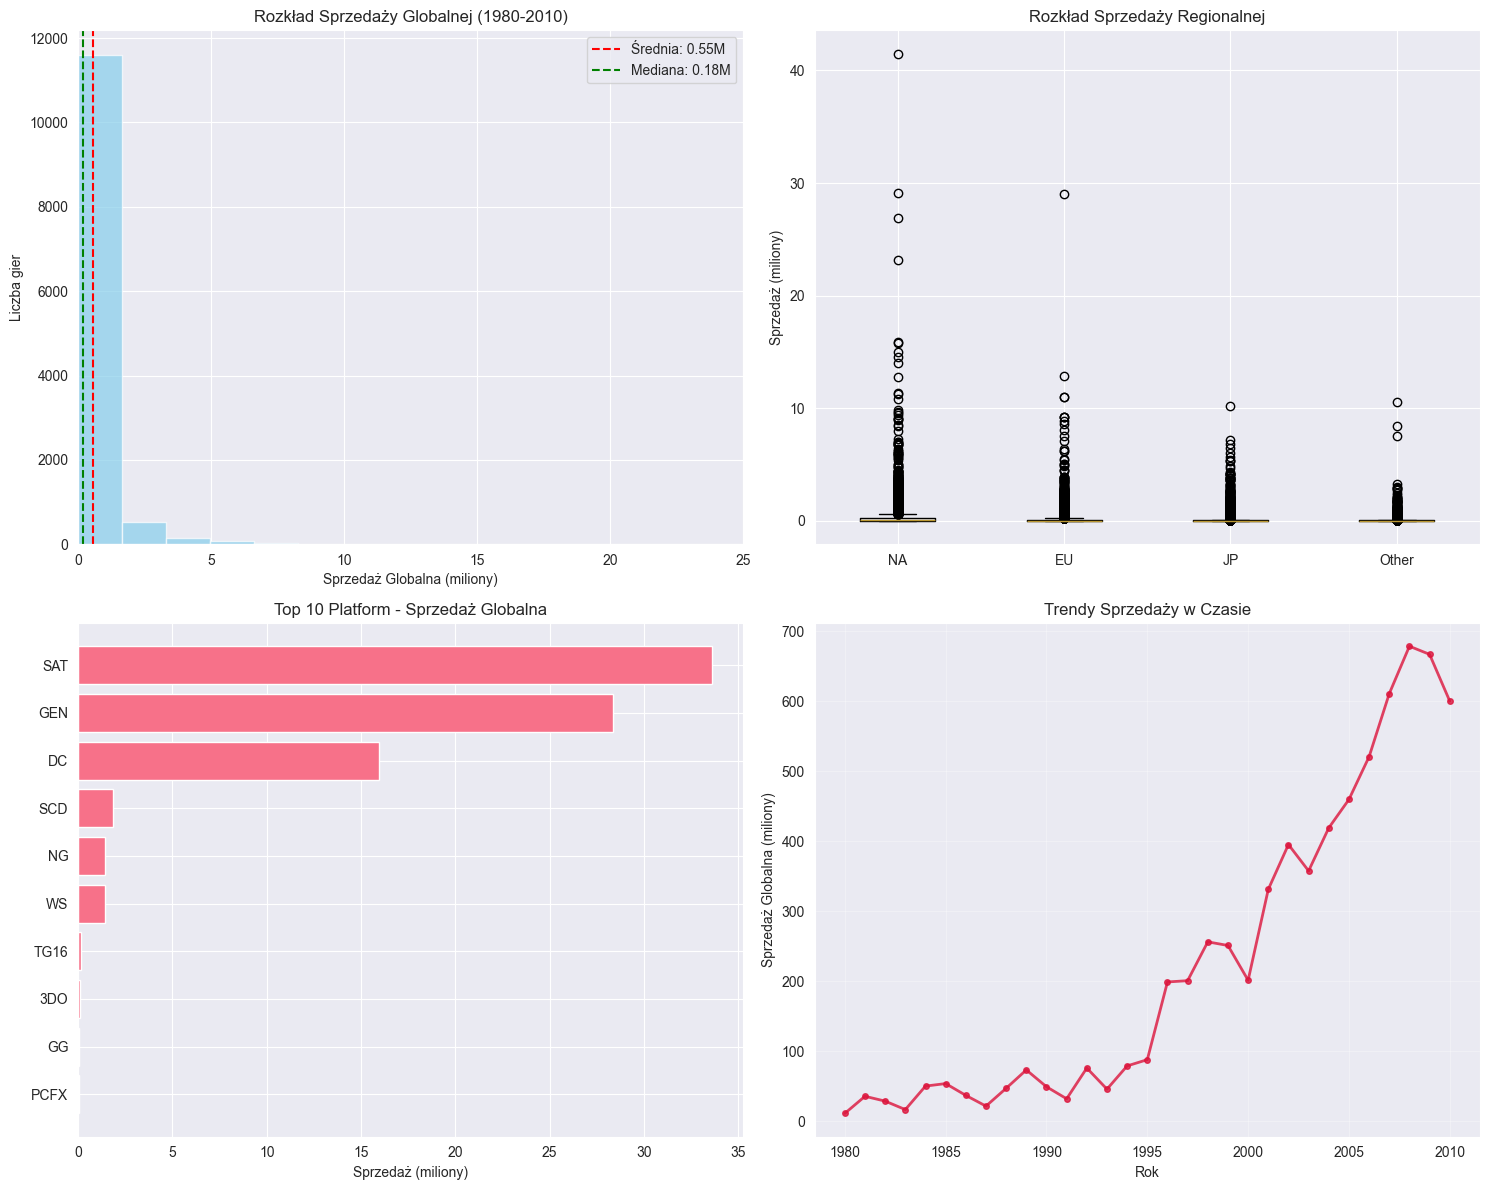

In [9]:

# ========================================
# 7. TWORZENIE WIZUALIZACJI NA DANYCH WYSOKIEJ JAKOŚCI
# ========================================

print("\n\n7. TWORZENIE WIZUALIZACJI NA DANYCH WYSOKIEJ JAKOŚCI")
print("-" * 50)

# UWAGA: Wszystkie wizualizacje używają danych wysokiej jakości (1980-2010)
print("\n⚠️ UWAGA: Wszystkie wizualizacje używają danych wysokiej jakości (1980-2010)")

# Ograniczenie do lat 1980-2010
df_quality = df[df['Year'] <= 2010].copy()

print(f"\n📊 Dane wysokiej jakości (1980-2010):")
print(f"   • Rekordy w zakresie HQ: {len(df_quality):,} gier")
print(f"   • Procent datasetu: {len(df_quality)/len(df)*100:.0f}%")
print(f"   • Rekomendacja: użyć tego zakresu dla kluczowych analiz")

# Podstawowa Analiza Rozkładu Sprzedaży
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Rozkład sprzedaży globalnej
axes[0,0].hist(df_quality['Global_Sales'], bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Rozkład Sprzedaży Globalnej (1980-2010)')
axes[0,0].set_xlabel('Sprzedaż Globalna (miliony)')
axes[0,0].set_ylabel('Liczba gier')
axes[0,0].axvline(df_quality['Global_Sales'].mean(), color='red', linestyle='--', 
                 label=f'Średnia: {df_quality["Global_Sales"].mean():.2f}M')
axes[0,0].axvline(df_quality['Global_Sales'].median(), color='green', linestyle='--', 
                 label=f'Mediana: {df_quality["Global_Sales"].median():.2f}M')
axes[0,0].legend()
axes[0,0].set_xlim(0, 25)

# 2. Box plot sprzedaży regionalnej
regional_data = df_quality[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
bp = axes[0,1].boxplot([regional_data[col] for col in regional_data.columns],
                       labels=['NA', 'EU', 'JP', 'Other'])
axes[0,1].set_title('Rozkład Sprzedaży Regionalnej')
axes[0,1].set_ylabel('Sprzedaż (miliony)')

# 3. Top 10 platform - POSORTOWANE
platform_sales_quality = df_quality.groupby('Platform').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=True)

top_platforms = platform_sales_quality.head(10)
axes[1,0].barh(range(len(top_platforms)), top_platforms['Global_Sales'])
axes[1,0].set_yticks(range(len(top_platforms)))
axes[1,0].set_yticklabels(top_platforms.index)
axes[1,0].set_title('Top 10 Platform - Sprzedaż Globalna')
axes[1,0].set_xlabel('Sprzedaż (miliony)')

# 4. Trendy w czasie - ULEPSZONE
yearly_sales = df_quality.groupby('Year')['Global_Sales'].sum()
axes[1,1].plot(yearly_sales.index, yearly_sales.values, marker='o', linewidth=2,
               markersize=4, color='crimson', alpha=0.8)
axes[1,1].set_title('Trendy Sprzedaży w Czasie')
axes[1,1].set_xlabel('Rok')
axes[1,1].set_ylabel('Sprzedaż Globalna (miliony)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:

# ========================================
# 8. PRZYGOTOWANIE DANYCH DO DALSZEJ ANALIZY
# ========================================

print("\n\n8. PRZYGOTOWANIE DANYCH DO DALSZEJ ANALIZY")
print("-" * 50)

# Tworzenie kopii danych do oczyszczenia
df_clean = df.copy()

print("\n✅ Rozpoczęcie procesu oczyszczania...")

# 1. Usunięcie gier z zerową sprzedażą
initial_count = len(df_clean)
df_clean = df_clean[df_clean['Global_Sales'] > 0]
removed_zero = initial_count - len(df_clean)
print(f"   ✓ Usunięto {removed_zero} gier z zerową sprzedażą")

# 2. Korekta niespójności w sumowaniu (opcjonalne - tutaj tylko flagowanie)
df_clean['Sales_Consistent'] = np.abs(
    (df_clean['NA_Sales'] + df_clean['EU_Sales'] + 
     df_clean['JP_Sales'] + df_clean['Other_Sales']) -
    df_clean['Global_Sales']
) <= 0.01

inconsistent_count = (~df_clean['Sales_Consistent']).sum()
print(f"   ⚠️ Flagowanie {inconsistent_count} niespójnych rekordów")

# 3. Dodanie kategorii dekad - POPRAWKA błędu z NaN
df_clean['Decade'] = df_clean['Year'].fillna(0) # Wypełnij NaN zerami tymczasowo
df_clean['Decade'] = (df_clean['Decade'] // 10 * 10).astype(int)
df_clean.loc[df_clean['Year'].isna(), 'Decade'] = np.nan  # Przywróć NaN gdzie były
print(f"   ✓ Dodano kategorię dekad (obsłużono NaN)")

# 4. Dodanie kategorii sukcesu
df_clean['Success_Category'] = pd.cut(df_clean['Global_Sales'], 
                                     bins=[0, 1, 5, 10, 50, float('inf')],
                                     labels=['Low', 'Medium', 'High', 'Very High', 'Blockbuster'])
print(f"   ✓ Dodano kategorię sukcesu sprzedażowego")

# 5. Dodanie udziału regionalnego
df_clean['NA_Share'] = df_clean['NA_Sales'] / df_clean['Global_Sales'] * 100
df_clean['EU_Share'] = df_clean['EU_Sales'] / df_clean['Global_Sales'] * 100
df_clean['JP_Share'] = df_clean['JP_Sales'] / df_clean['Global_Sales'] * 100
df_clean['Other_Share'] = df_clean['Other_Sales'] / df_clean['Global_Sales'] * 100
print(f"   ✓ Dodano udziały sprzedaży regionalnej")

# 6. Standaryzacja nazw platform (grupowanie podobnych)
platform_mapping = {
    'PS': 'PlayStation', 'PS2': 'PlayStation', 'PS3': 'PlayStation', 'PS4': 'PlayStation',
    'PSP': 'PlayStation Portable', 'PSV': 'PlayStation Portable',
    'X360': 'Xbox', 'XB': 'Xbox', 'XOne': 'Xbox',
    'Wii': 'Nintendo Console', 'WiiU': 'Nintendo Console',
    'NES': 'Nintendo Console', 'N64': 'Nintendo Console', 'GC': 'Nintendo Console',
    'GB': 'Nintendo Handheld', 'GBA': 'Nintendo Handheld', 'DS': 'Nintendo Handheld'
}

df_clean['Platform_Family'] = df_clean['Platform'].map(platform_mapping).fillna(df_clean['Platform'])
print(f"   ✓ Zgrupowano platformy w rodziny")

# Podsumowanie oczyszczonych danych
print(f"\n📊 Podsumowanie oczyszczonych danych:")
print(f"   • Oryginalne rekordy: {len(df):,}")
print(f"   • Oczyszczone rekordy: {len(df_clean):,}")
print(f"   • Usunięte rekordy: {len(df) - len(df_clean):,}")
print(f"   • Nowe kolumny: {len(df_clean.columns) - len(df.columns)}")
print(f"   • ZACHOWANO wszystkie gry topowe i historyczne")
print(f"   • Utworzono kategorię sukcesu zamiast usuwania outlierów")

# Dodatkowe podsumowanie według zakresu czasowego
cutoff_year = 2010  # Na podstawie analizy z pkt 2.5
quality_data = df_clean[df_clean['Year'] <= cutoff_year]
print(f"\n🎯 Dane wysokiej jakości (1980-{cutoff_year}):")
print(f"   • Rekordy w zakresie HQ: {len(quality_data):,}")
print(f"   • Procent datasetu: {len(quality_data)/len(df_clean)*100:.1f}%")
print(f"   • Rekomendacja: użyć tego zakresu dla kluczowych analiz")



8. PRZYGOTOWANIE DANYCH DO DALSZEJ ANALIZY
--------------------------------------------------

✅ Rozpoczęcie procesu oczyszczania...
   ✓ Usunięto 0 gier z zerową sprzedażą
   ⚠️ Flagowanie 2625 niespójnych rekordów
   ✓ Dodano kategorię dekad (obsłużono NaN)
   ✓ Dodano kategorię sukcesu sprzedażowego
   ✓ Dodano udziały sprzedaży regionalnej
   ✓ Zgrupowano platformy w rodziny

📊 Podsumowanie oczyszczonych danych:
   • Oryginalne rekordy: 16,598
   • Oczyszczone rekordy: 16,598
   • Usunięte rekordy: 0
   • Nowe kolumny: 8
   • ZACHOWANO wszystkie gry topowe i historyczne
   • Utworzono kategorię sukcesu zamiast usuwania outlierów

🎯 Dane wysokiej jakości (1980-2010):
   • Rekordy w zakresie HQ: 12,441
   • Procent datasetu: 75.0%
   • Rekomendacja: użyć tego zakresu dla kluczowych analiz


In [11]:

# ========================================
# 8.1. SZCZEGÓŁOWA ANALIZA OCZYSZCZONYCH DANYCH
# ========================================

print("\n\n8.1. SZCZEGÓŁOWA ANALIZA OCZYSZCZONYCH DANYCH")
print("-" * 50)

# Porównanie trzech wersji danych
print("\n📊 Porównanie trzech wersji danych:")
print(f"   • df (oryginalny): {len(df)} rekordów")
print(f"   • df_quality (1980-2010): {len(df_quality)} rekordów")
print(f"   • df_clean (oczyszczony): {len(df_clean)} rekordów")

# Analiza nowych kolumn
print("\n🔍 Analiza nowych kolumn:")

# Kategorie sukcesu
print("\n   • Kategorie sukcesu:")
success_dist = df_clean['Success_Category'].value_counts()
for category, count in success_dist.items():
    percentage = (count / len(df_clean)) * 100
    print(f"      - {category}: {count:,} gier ({percentage:.1f}%)")

# Rodziny platform
print("\n   • Rodziny platform:")
platform_family_dist = df_clean['Platform_Family'].value_counts()
for family, count in platform_family_dist.head(5).items():
    percentage = (count / len(df_clean)) * 100
    print(f"      - {family}: {count:,} gier ({percentage:.1f}%)")

# Średnie udziały regionalne
print("\n   • Średnie udziały regionalne:")
print(f"      - NA: {df_clean['NA_Share'].mean():.1f}%")
print(f"      - EU: {df_clean['EU_Share'].mean():.1f}%")
print(f"      - JP: {df_clean['JP_Share'].mean():.1f}%")
print(f"      - Other: {df_clean['Other_Share'].mean():.1f}%")

# Przykłady z każdej kategorii sukcesu
print("\n🏆 Przykłady z każdej kategorii sukcesu:")
for category in ['Blockbuster', 'Hit', 'Successful', 'Standard', 'Niche']:
    examples = df_clean[df_clean['Success_Category'] == category].nlargest(2, 'Global_Sales')
    if len(examples) > 0:
        print(f"\n   • {category}:")
        for _, game in examples.iterrows():
            print(f"      - {game['Name']} ({game['Platform']}): {game['Global_Sales']:.1f}M")

# Rekomendacje do dalszej analizy
print("\n💡 REKOMENDACJE UŻYCIA RÓŻNYCH WERSJI:")
print("   • df_quality (1980-2010): główne analizy trendów i wzorców")
print("   • df_clean: modelowanie ML i segmentacja")
print("   • df (pełny): kontekst historyczny i completeness check")



8.1. SZCZEGÓŁOWA ANALIZA OCZYSZCZONYCH DANYCH
--------------------------------------------------

📊 Porównanie trzech wersji danych:
   • df (oryginalny): 16598 rekordów
   • df_quality (1980-2010): 12441 rekordów
   • df_clean (oczyszczony): 16598 rekordów

🔍 Analiza nowych kolumn:

   • Kategorie sukcesu:
      - Low: 14,544 gier (87.6%)
      - Medium: 1,849 gier (11.1%)
      - High: 143 gier (0.9%)
      - Very High: 61 gier (0.4%)
      - Blockbuster: 1 gier (0.0%)

   • Rodziny platform:
      - PlayStation: 5,022 gier (30.3%)
      - Nintendo Handheld: 3,083 gier (18.6%)
      - Nintendo Console: 2,441 gier (14.7%)
      - Xbox: 2,302 gier (13.9%)
      - PlayStation Portable: 1,626 gier (9.8%)

   • Średnie udziały regionalne:
      - NA: 45.6%
      - EU: 22.9%
      - JP: 24.2%
      - Other: 6.5%

🏆 Przykłady z każdej kategorii sukcesu:

   • Blockbuster:
      - Wii Sports (Wii): 82.7M

💡 REKOMENDACJE UŻYCIA RÓŻNYCH WERSJI:
   • df_quality (1980-2010): główne analizy tre

In [12]:

# ========================================
# 9. EKSPORT OCZYSZCZONYCH DANYCH
# ========================================

print("\n\n9. EKSPORT OCZYSZCZONYCH DANYCH")
print("-" * 50)

# Zapisanie oczyszczonych danych
df_clean.to_csv('video_games_sales_cleaned.csv', index=False)
print("\n✅ Oczyszczone dane zapisane jako 'video_games_sales_cleaned.csv'")

# Raport jakości danych
quality_report = {
    'Original_Records': len(df),
    'Cleaned_Records': len(df_clean),
    'Removed_Records': len(df) - len(df_clean),
    'Missing_Data_Percent': df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100,
    'Outliers_Percent': global_outliers['outliers_percent'],
    'Inconsistent_Sales': inconsistent_count
}

print("\n📋 Raport jakości danych:")
for key, value in quality_report.items():
    if 'Percent' in key:
        print(f"   • {key.replace('_', ' ')}: {value:.2f}%")
    else:
        print(f"   • {key.replace('_', ' ')}: {value:,}")



9. EKSPORT OCZYSZCZONYCH DANYCH
--------------------------------------------------

✅ Oczyszczone dane zapisane jako 'video_games_sales_cleaned.csv'

📋 Raport jakości danych:
   • Original Records: 16,598
   • Cleaned Records: 16,598
   • Removed Records: 0
   • Missing Data Percent: 0.18%
   • Outliers Percent: 11.40%
   • Inconsistent Sales: 2,625




10. REKOMENDACJE DLA DALSZEJ ANALIZY
--------------------------------------------------

Następne kroki w projekcie:
   1. 🔍 Analiza segmentacji rynku przy użyciu algorytmów klastrowania
   2. 📉 Modelowanie predykcyjne sukcesu gier na podstawie cech
   3. 🌍 Analiza różnic preferencji między regionami geograficznymi
   4. ⏰ Badanie cykli życia platform i ewolucji gatunków
   5. 🎯 Identyfikacja czynników wpływających na sukces wydawców
   6. 📊 Tworzenie interaktywnego dashboardu do eksploracji danych
   7. 🔄 Zastosowanie algorytmów ML do przewidywania sprzedaży
   8. ✨ Analiza trendów i prognozowanie przyszłego rozwoju rynku

❇️ NAJWAŻNIEJSZE ODKRYCIA DO PREZENTACJI:
   1. 'Golden Age' 2006-2009: szczyt branży, wzrost sprzedaży o >150%
   2. Nintendo jako disruptor: zdominowało rynek dzięki innowacjom
   3. Motion control rewolucja: Sports games boom w erze Wii
   4. Ewolucja gatunków: Platform → Action jako dominujący
   5. Cykle życia platform: skracanie się w czasie (tech accelerati

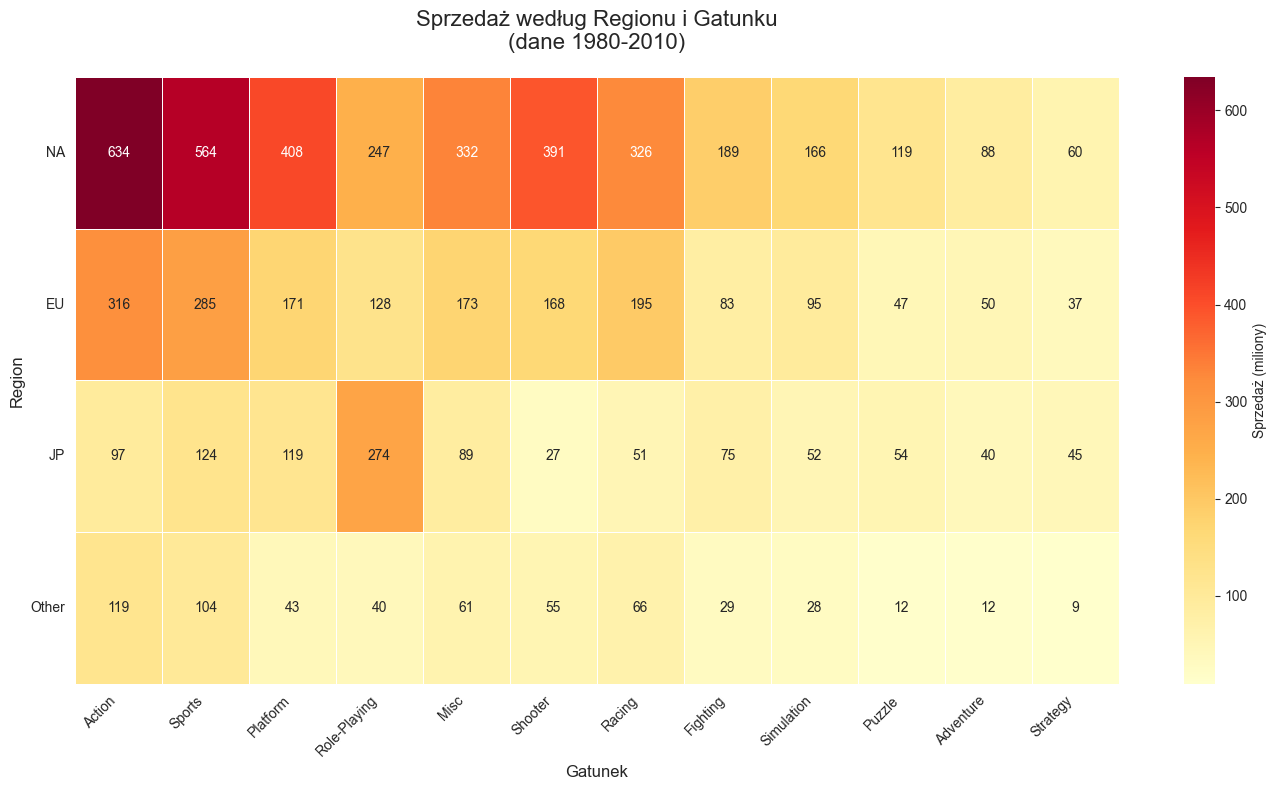

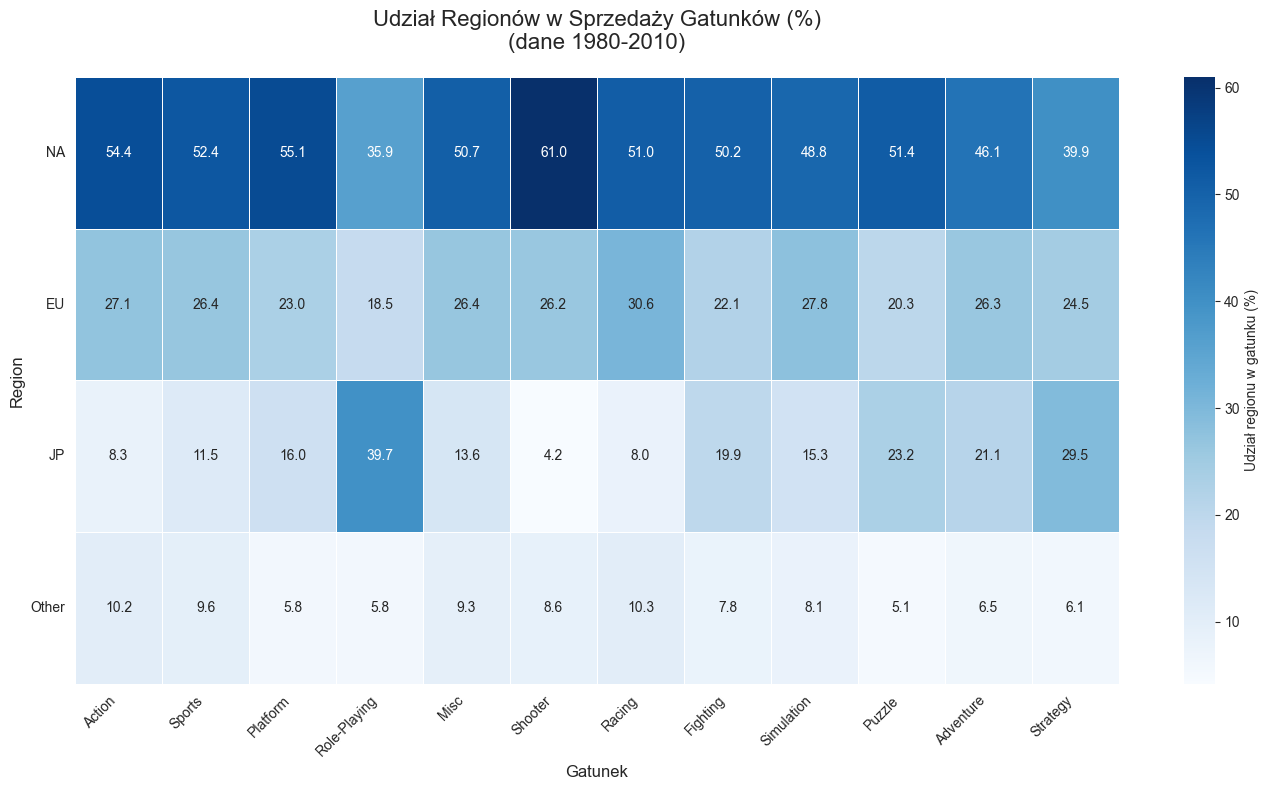

In [13]:

# ========================================
# 10. REKOMENDACJE DLA DALSZEJ ANALIZY
# ========================================

print("\n\n10. REKOMENDACJE DLA DALSZEJ ANALIZY")
print("-" * 50)

print("\nNastępne kroki w projekcie:")
recommendations = [
    "🔍 Analiza segmentacji rynku przy użyciu algorytmów klastrowania",
    "📉 Modelowanie predykcyjne sukcesu gier na podstawie cech",
    "🌍 Analiza różnic preferencji między regionami geograficznymi",
    "⏰ Badanie cykli życia platform i ewolucji gatunków",
    "🎯 Identyfikacja czynników wpływających na sukces wydawców",
    "📊 Tworzenie interaktywnego dashboardu do eksploracji danych",
    "🔄 Zastosowanie algorytmów ML do przewidywania sprzedaży",
    "✨ Analiza trendów i prognozowanie przyszłego rozwoju rynku"
]

for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

print(f"\n❇️ NAJWAŻNIEJSZE ODKRYCIA DO PREZENTACJI:")
key_findings = [
    "'Golden Age' 2006-2009: szczyt branży, wzrost sprzedaży o >150%",
    "Nintendo jako disruptor: zdominowało rynek dzięki innowacjom",
    "Motion control rewolucja: Sports games boom w erze Wii",
    "Ewolucja gatunków: Platform → Action jako dominujący",
    "Cykle życia platform: skracanie się w czasie (tech acceleration)",
    "Regionalne różnice: kultura wpływa na preferencję gatunków",
    "Spadek post-2010: konieczność analizy digitalizacji rynku"
]

for i, finding in enumerate(key_findings, 1):
    print(f"   {i}. {finding}")

print("\n" + "="*80)
print("ANALIZA WSTĘPNA ZAKOŃCZONA POMYŚLNIE!")
print("Dane gotowe do zaawansowanej analizy i modelowania.")
print("="*80)

# ========================================
# 9. HEATMAPY - PREFERENCJE REGIONALNE VS GATUNKI
# ========================================

print("\n\n9. HEATMAPY - PREFERENCJE REGIONALNE VS GATUNKI") 
print("-" * 50)

# Przygotowanie danych dla heatmap region vs gatunek
def create_region_genre_heatmap(df):
    """Przygotowanie danych - melt regionów"""
    regions_df = pd.melt(df,
                        id_vars=['Genre'],
                        value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'],
                        var_name='Region', value_name='Sales')
    
    # Oczyszczenie nazw regionów
    regions_df['Region'] = regions_df['Region'].str.replace('_Sales', '')
    
    # Agregacja sprzedaży według regionu i gatunku
    heatmap_data = regions_df.groupby(['Region', 'Genre'])['Sales'].sum().unstack()
    
    # Sortowanie regionów według całkowitej sprzedaży
    region_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
    heatmap_data = heatmap_data.loc[region_totals.index]
    
    # Sortowanie gatunków według całkowitej sprzedaży
    genre_totals = heatmap_data.sum(axis=0).sort_values(ascending=False)
    heatmap_data = heatmap_data[genre_totals.index]
    
    return heatmap_data

# Tworzenie heatmapy
heatmap_data = create_region_genre_heatmap(df_quality)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data,
           annot=True,
           fmt='.0f',
           cmap='YlOrRd',
           cbar_kws={'label': 'Sprzedaż (miliony)'},
           linewidths=0.5)
plt.title('Sprzedaż według Regionu i Gatunku\n(dane 1980-2010)', fontsize=16, pad=20)
plt.xlabel('Gatunek', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Dodatkowa analiza - procnetowy udział każdego regionu w gatunku
plt.figure(figsize=(14, 8))
heatmap_percent = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100
sns.heatmap(heatmap_percent,
           annot=True,
           fmt='.1f',
           cmap='Blues',
           cbar_kws={'label': 'Udział regionu w gatunku (%)'},
           linewidths=0.5)
plt.title('Udział Regionów w Sprzedaży Gatunków (%)\n(dane 1980-2010)', fontsize=16, pad=20)
plt.xlabel('Gatunek', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:

# ========================================
# 10. TOP GIRY W POSZCZEGÓLNYCH LATACH - JAK PROSIŁ UŻYTKOWNIK
# ========================================

print("\n\n10. TOP GIRY W POSZCZEGÓLNYCH LATACH (2000-2010)")
print("-" * 50)

for year in range(2000, 2011):
    year_games = df_quality[df_quality['Year'] == year].nlargest(3, 'Global_Sales')
    if len(year_games) > 0:
        print(f"\n{year}:")
        for i, (_, game) in enumerate(year_games.iterrows(), 1):
            print(f"   {i}. {game['Name']} ({game['Platform']}): {game['Global_Sales']:.1f}M")



10. TOP GIRY W POSZCZEGÓLNYCH LATACH (2000-2010)
--------------------------------------------------

2000:
   1. Pokémon Crystal Version (GB): 6.4M
   2. Final Fantasy IX (PS): 5.3M
   3. Driver 2 (PS): 4.7M

2001:
   1. Gran Turismo 3: A-Spec (PS2): 15.0M
   2. Grand Theft Auto III (PS2): 13.1M
   3. Final Fantasy X (PS2): 8.1M

2002:
   1. Grand Theft Auto: Vice City (PS2): 16.1M
   2. Pokemon Ruby/Pokemon Sapphire (GBA): 15.8M
   3. Medal of Honor: Frontline (PS2): 6.8M

2003:
   1. Need for Speed Underground (PS2): 7.2M
   2. Mario Kart: Double Dash!! (GC): 7.0M
   3. Final Fantasy X-2 (PS2): 5.3M

2004:
   1. Grand Theft Auto: San Andreas (PS2): 20.8M
   2. Gran Turismo 4 (PS2): 11.7M
   3. Pokemon FireRed/Pokemon LeafGreen (GBA): 10.5M

2005:
   1. Nintendogs (DS): 24.8M
   2. Mario Kart DS (DS): 23.4M
   3. Brain Age: Train Your Brain in Minutes a Day (DS): 20.2M

2006:
   1. Wii Sports (Wii): 82.7M
   2. New Super Mario Bros. (DS): 30.0M
   3. Wii Play (Wii): 29.0M

2007:
   



14. DODATKOWA ANALIZA EDA - TRENDY I WZORCE
--------------------------------------------------

📈 Analiza dominacji wydawców w czasie:
   • 1990: Nintendo (35.5M)
   • 1995: Sony Computer Entertainment (18.4M)
   • 2000: Nintendo (34.0M)
   • 2005: Nintendo (127.5M)
   • 2010: Electronic Arts (81.4M)

🔄 Analiza cykli życia platform:


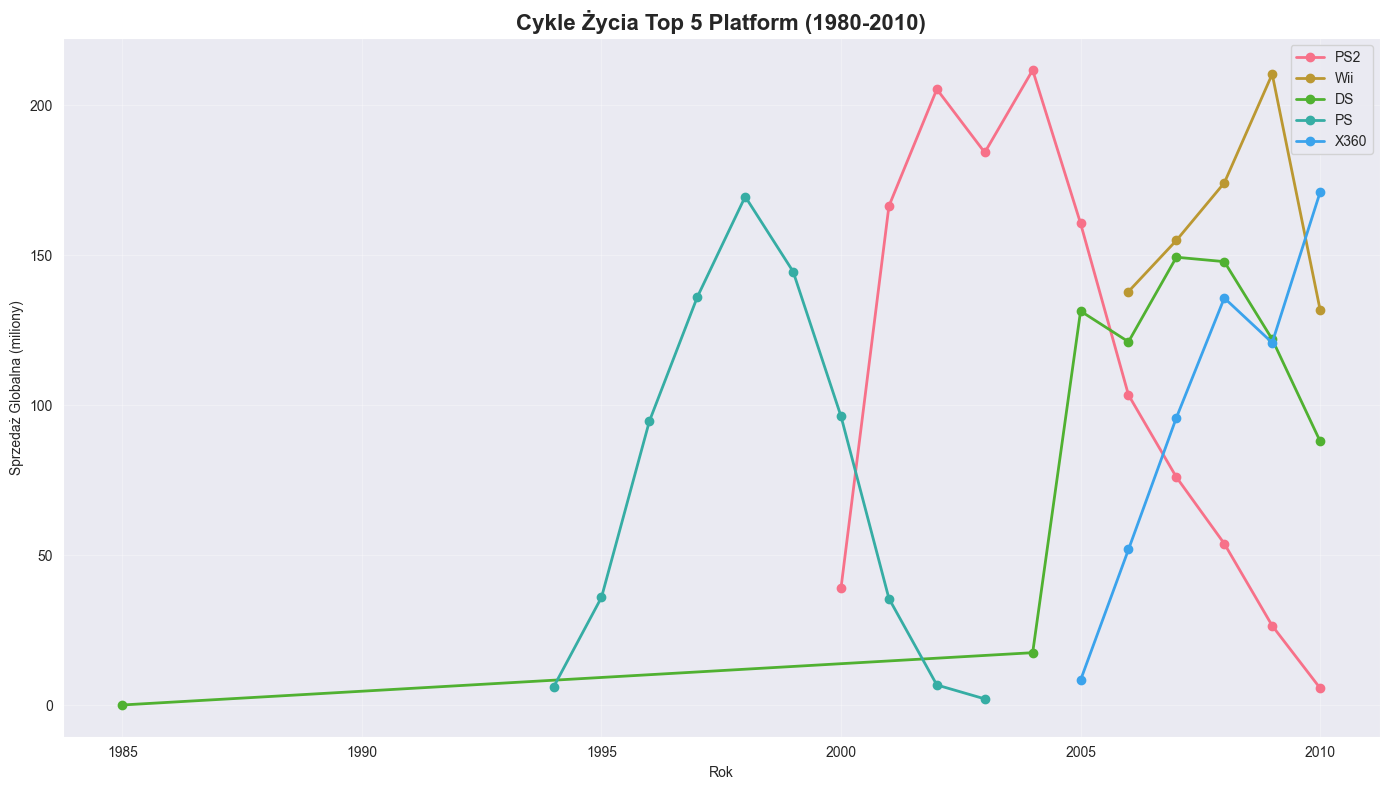


🌍 Analiza preferencji regionalnych:

Dominujący region dla każdego gatunku:
   • Action: NA (54.4%)
   • Adventure: NA (46.1%)
   • Fighting: NA (50.2%)
   • Misc: NA (50.7%)
   • Platform: NA (55.1%)
   • Puzzle: NA (51.4%)
   • Racing: NA (51.0%)
   • Role-Playing: JP (39.7%)
   • Shooter: NA (61.0%)
   • Simulation: NA (48.8%)
   • Sports: NA (52.4%)
   • Strategy: NA (39.9%)


In [15]:

# ========================================
# 14. DODATKOWA ANALIZA EDA - TRENDY I WZORCE
# ========================================

print("\n\n14. DODATKOWA ANALIZA EDA - TRENDY I WZORCE")
print("-" * 50)

# Analiza trendów wydawców w czasie
print("\n📈 Analiza dominacji wydawców w czasie:")

# Wybieramy lata kluczowe
key_years = [1990, 1995, 2000, 2005, 2010]
for year in key_years:
    year_data = df_quality[df_quality['Year'] == year]
    if len(year_data) > 0:
        top_publisher = year_data.groupby('Publisher')['Global_Sales'].sum().nlargest(1)
        print(f"   • {year}: {top_publisher.index[0]} ({top_publisher.values[0]:.1f}M)")

# Analiza cykli życia platform
print("\n🔄 Analiza cykli życia platform:")
platform_lifecycle = df_quality.groupby(['Platform', 'Year'])['Global_Sales'].sum().reset_index()

# Wybieramy top 5 platform
top_platforms_list = df_quality.groupby('Platform')['Global_Sales'].sum().nlargest(5).index

plt.figure(figsize=(14, 8))
for platform in top_platforms_list:
    platform_data = platform_lifecycle[platform_lifecycle['Platform'] == platform]
    plt.plot(platform_data['Year'], platform_data['Global_Sales'], 
             marker='o', label=platform, linewidth=2)

plt.title('Cykle Życia Top 5 Platform (1980-2010)', fontsize=16, fontweight='bold')
plt.xlabel('Rok')
plt.ylabel('Sprzedaż Globalna (miliony)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analiza preferencji regionalnych dla gatunków
print("\n🌍 Analiza preferencji regionalnych:")
regional_prefs = df_quality.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
regional_prefs_pct = regional_prefs.div(regional_prefs.sum(axis=1), axis=0) * 100

print("\nDominujący region dla każdego gatunku:")
for genre in regional_prefs_pct.index:
    dominant_region = regional_prefs_pct.loc[genre].idxmax().replace('_Sales', '')
    dominant_pct = regional_prefs_pct.loc[genre].max()
    print(f"   • {genre}: {dominant_region} ({dominant_pct:.1f}%)")

In [16]:

# ========================================
# 15. IDENTYFIKACJA WZORCÓW BIZNESOWYCH
# ========================================

print("\n\n15. IDENTYFIKACJA WZORCÓW BIZNESOWYCH")
print("-" * 50)

# Analiza strategii wydawców
print("\n🏢 Analiza strategii wydawców:")

publisher_strategy = df_quality.groupby('Publisher').agg({
    'Name': 'count',
    'Global_Sales': ['sum', 'mean'],
    'Platform': lambda x: x.nunique(),
    'Genre': lambda x: x.nunique()
}).round(2)

publisher_strategy.columns = ['Games_Count', 'Total_Sales', 'Avg_Sales_Per_Game', 
                             'Platform_Diversity', 'Genre_Diversity']
publisher_strategy = publisher_strategy[publisher_strategy['Games_Count'] >= 50]  # Tylko duzi wydawcy
publisher_strategy = publisher_strategy.sort_values('Total_Sales', ascending=False).head(10)

print("\nTop 10 wydawców - analiza strategii:")
print("(Wydawca | Gry | Sprzedaż | Śr/grę | Platformy | Gatunki)")
print("-" * 60)
for publisher, row in publisher_strategy.iterrows():
    print(f"{publisher[:20]:20s} | {int(row['Games_Count']):4d} | {row['Total_Sales']:7.1f}M | "
          f"{row['Avg_Sales_Per_Game']:5.2f}M | {int(row['Platform_Diversity']):9d} | "
          f"{int(row['Genre_Diversity']):7d}")

# Identyfikacja "jednego hitu" vs "portfolio"
print("\n💡 Typy strategii wydawców:")

# Wydawcy z jednym wielkim hitem
one_hit_publishers = []
portfolio_publishers = []

for publisher in publisher_strategy.index:
    publisher_games = df_quality[df_quality['Publisher'] == publisher]
    top_game_sales = publisher_games['Global_Sales'].max()
    total_sales = publisher_games['Global_Sales'].sum()
    
    if top_game_sales / total_sales > 0.5:  # Ponad 50% sprzedaży z jednej gry
        one_hit_publishers.append((publisher, top_game_sales / total_sales))
    else:
        portfolio_publishers.append((publisher, top_game_sales / total_sales))

print("\n🎯 Wydawcy 'jednego hitu' (>50% sprzedaży z top gry):")
for pub, ratio in sorted(one_hit_publishers, key=lambda x: x[1], reverse=True)[:5]:
    print(f"   • {pub}: {ratio:.1%} sprzedaży z top gry")

print("\n📚 Wydawcy 'portfolio' (zdywersyfikowana sprzedaż):")
for pub, ratio in sorted(portfolio_publishers, key=lambda x: x[1])[:5]:
    print(f"   • {pub}: tylko {ratio:.1%} sprzedaży z top gry")



15. IDENTYFIKACJA WZORCÓW BIZNESOWYCH
--------------------------------------------------

🏢 Analiza strategii wydawców:

Top 10 wydawców - analiza strategii:
(Wydawca | Gry | Sprzedaż | Śr/grę | Platformy | Gatunki)
------------------------------------------------------------
Nintendo             |  554 |  1544.4M |  2.79M |         8 |      12
Electronic Arts      | 1087 |   813.9M |  0.75M |        14 |      12
Sony Computer Entert |  582 |   517.8M |  0.89M |         4 |      12
Activision           |  716 |   489.1M |  0.68M |        15 |      12
THQ                  |  627 |   306.6M |  0.49M |        13 |      12
Ubisoft              |  680 |   296.0M |  0.44M |        14 |      12
Take-Two Interactive |  293 |   259.1M |  0.88M |        12 |      11
Konami Digital Enter |  693 |   242.1M |  0.35M |        19 |      12
Sega                 |  512 |   231.4M |  0.45M |        16 |      12
Namco Bandai Games   |  527 |   174.0M |  0.33M |        18 |      12

💡 Typy strategii wyd



16. ZAAWANSOWANE WIZUALIZACJE KOŃCOWE
--------------------------------------------------


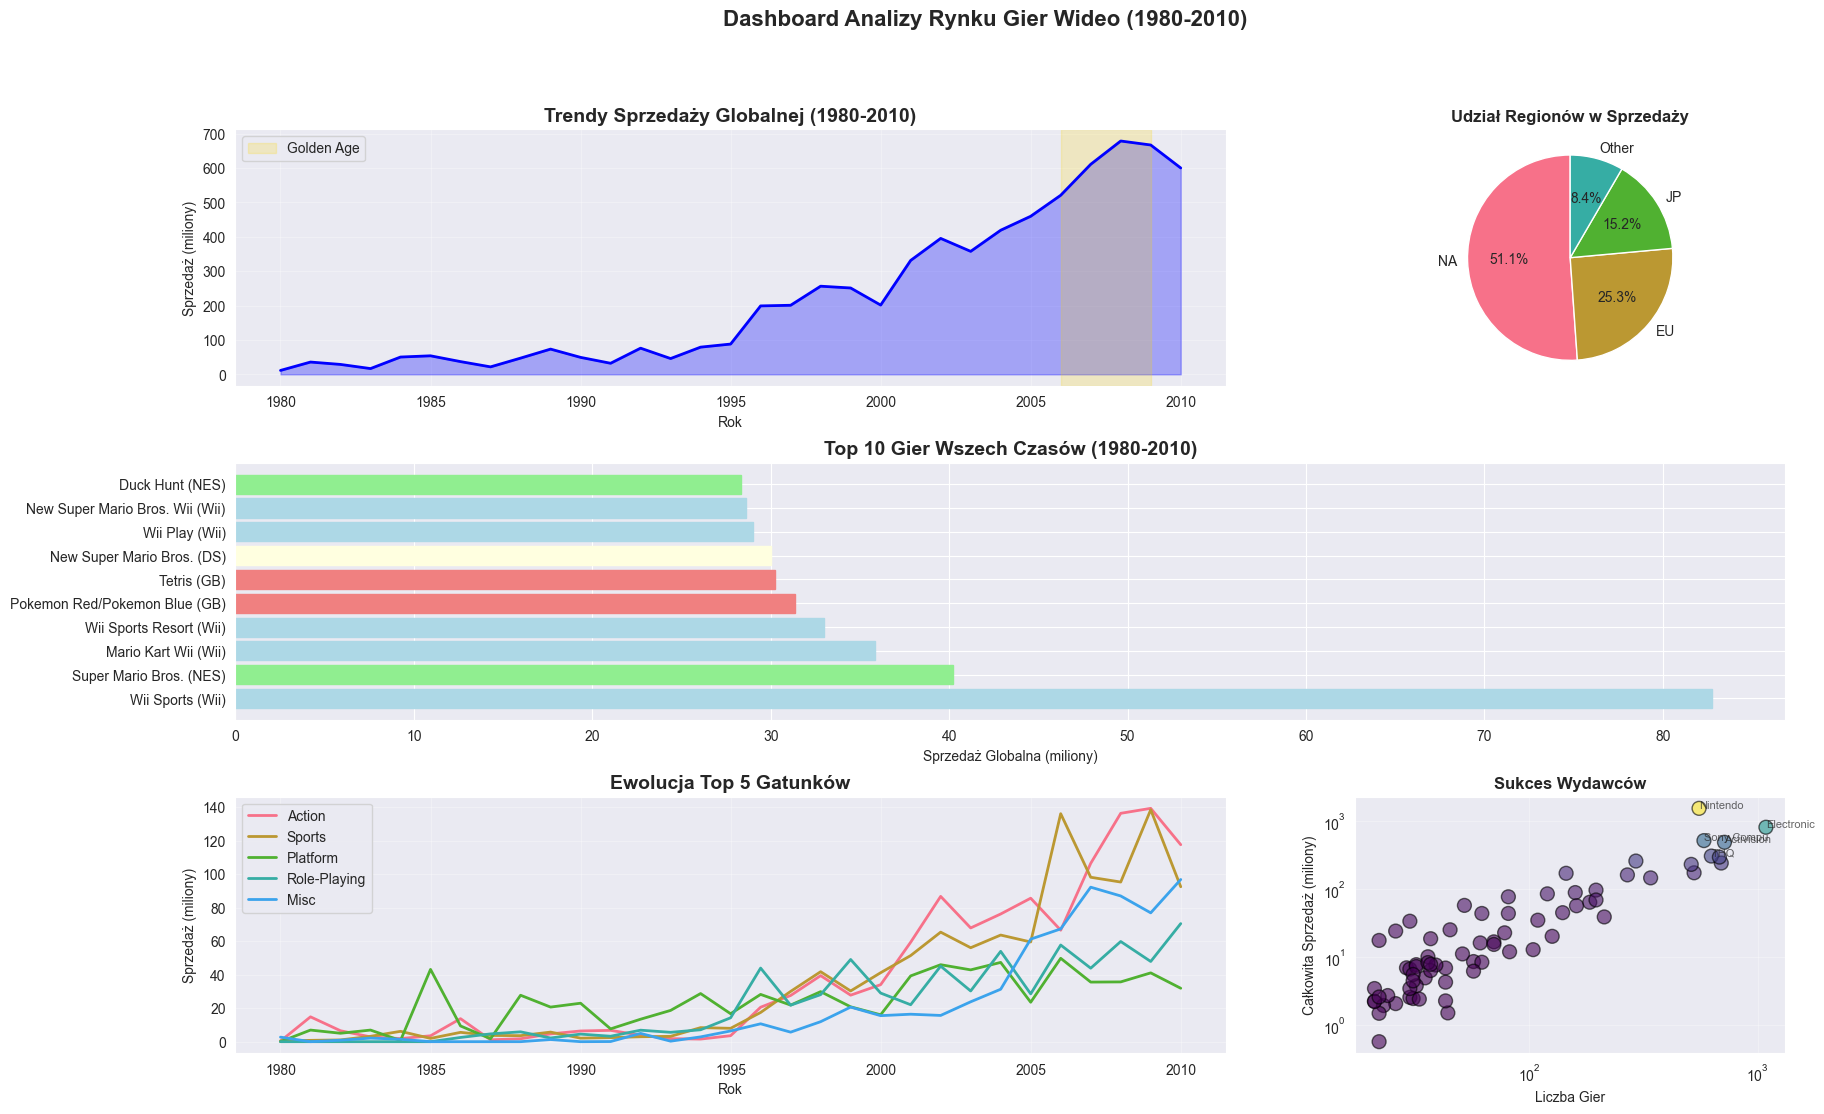

In [17]:

# ========================================
# 16. ZAAWANSOWANE WIZUALIZACJE KOŃCOWE
# ========================================

print("\n\n16. ZAAWANSOWANE WIZUALIZACJE KOŃCOWE")
print("-" * 50)

# Złożona wizualizacja - Dashboard style
fig = plt.figure(figsize=(20, 12))

# Grid layout
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Trendy sprzedaży globalnej
ax1 = fig.add_subplot(gs[0, :2])
yearly_sales = df_quality.groupby('Year')['Global_Sales'].sum()
ax1.fill_between(yearly_sales.index, yearly_sales.values, alpha=0.3, color='blue')
ax1.plot(yearly_sales.index, yearly_sales.values, 'b-', linewidth=2)
ax1.set_title('Trendy Sprzedaży Globalnej (1980-2010)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Rok')
ax1.set_ylabel('Sprzedaż (miliony)')
ax1.grid(True, alpha=0.3)

# Zaznaczenie "Golden Age"
ax1.axvspan(2006, 2009, alpha=0.2, color='gold', label='Golden Age')
ax1.legend()

# 2. Udział regionów
ax2 = fig.add_subplot(gs[0, 2])
regional_totals = df_quality[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
ax2.pie(regional_totals.values, labels=['NA', 'EU', 'JP', 'Other'], 
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Udział Regionów w Sprzedaży', fontsize=12, fontweight='bold')

# 3. Top 10 gier wszech czasów
ax3 = fig.add_subplot(gs[1, :])
top_games = df_quality.nlargest(10, 'Global_Sales')
bars = ax3.barh(range(len(top_games)), top_games['Global_Sales'])
ax3.set_yticks(range(len(top_games)))
ax3.set_yticklabels([f"{row['Name'][:30]} ({row['Platform']})" 
                     for _, row in top_games.iterrows()])
ax3.set_xlabel('Sprzedaż Globalna (miliony)')
ax3.set_title('Top 10 Gier Wszech Czasów (1980-2010)', fontsize=14, fontweight='bold')

# Kolorowanie według platform
platforms_colors = {'Wii': 'lightblue', 'NES': 'lightgreen', 'GB': 'lightcoral', 
                   'DS': 'lightyellow', 'X360': 'lightgray'}
for i, (_, game) in enumerate(top_games.iterrows()):
    color = platforms_colors.get(game['Platform'], 'lightsteelblue')
    bars[i].set_color(color)

# 4. Ewolucja gatunków
ax4 = fig.add_subplot(gs[2, :2])
genre_yearly = df_quality.groupby(['Year', 'Genre'])['Global_Sales'].sum().unstack(fill_value=0)
top_genres_list = genre_yearly.sum().nlargest(5).index

for genre in top_genres_list:
    ax4.plot(genre_yearly.index, genre_yearly[genre], label=genre, linewidth=2)

ax4.set_title('Ewolucja Top 5 Gatunków', fontsize=14, fontweight='bold')
ax4.set_xlabel('Rok')
ax4.set_ylabel('Sprzedaż (miliony)')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# 5. Mapa sukcesu wydawców
ax5 = fig.add_subplot(gs[2, 2])
publisher_success = df_quality.groupby('Publisher').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'})

# Tylko wydawcy z >20 grami
publisher_success = publisher_success[publisher_success['Games_Count'] > 20]

scatter = ax5.scatter(publisher_success['Games_Count'], 
                     publisher_success['Global_Sales'],
                     s=100, alpha=0.6, c=publisher_success['Global_Sales'],
                     cmap='viridis', edgecolors='black')

ax5.set_xlabel('Liczba Gier')
ax5.set_ylabel('Całkowita Sprzedaż (miliony)')
ax5.set_title('Sukces Wydawców', fontsize=12, fontweight='bold')
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.grid(True, alpha=0.3)

# Dodanie etykiet dla top wydawców
top_publishers = publisher_success.nlargest(5, 'Global_Sales')
for publisher, row in top_publishers.iterrows():
    ax5.annotate(publisher[:10], (row['Games_Count'], row['Global_Sales']),
                fontsize=8, alpha=0.7)

plt.suptitle('Dashboard Analizy Rynku Gier Wideo (1980-2010)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [18]:

# ========================================
# 17. EKSPORT WYNIKÓW I PODSUMOWANIE
# ========================================

print("\n\n17. EKSPORT WYNIKÓW I PODSUMOWANIE")
print("-" * 50)

# Zapisanie oczyszczonych danych
df_clean.to_csv('video_games_sales_cleaned.csv', index=False)
print("\n✅ Oczyszczone dane zapisane jako 'video_games_sales_cleaned.csv'")

# Zapisanie wyników analizy
analysis_results = {
    'total_games': len(df),
    'total_sales': df['Global_Sales'].sum(),
    'average_sales_per_game': df['Global_Sales'].mean(),
    'top_platform': df.groupby('Platform')['Global_Sales'].sum().idxmax(),
    'top_genre': df.groupby('Genre')['Global_Sales'].sum().idxmax(),
    'top_publisher': df.groupby('Publisher')['Global_Sales'].sum().idxmax(),
    'golden_age_years': '2006-2009',
    'na_dominance': (df['NA_Sales'].sum() / df['Global_Sales'].sum() * 100)
}

print("\n📊 PODSUMOWANIE KLUCZOWYCH STATYSTYK:")
print(f"   • Całkowita liczba gier: {analysis_results['total_games']:,}")
print(f"   • Całkowita sprzedaż: {analysis_results['total_sales']:,.1f}M")
print(f"   • Średnia sprzedaż/grę: {analysis_results['average_sales_per_game']:.2f}M")
print(f"   • Top platforma: {analysis_results['top_platform']}")
print(f"   • Top gatunek: {analysis_results['top_genre']}")
print(f"   • Top wydawca: {analysis_results['top_publisher']}")
print(f"   • Golden Age: {analysis_results['golden_age_years']}")
print(f"   • Dominacja NA: {analysis_results['na_dominance']:.1f}%")



17. EKSPORT WYNIKÓW I PODSUMOWANIE
--------------------------------------------------

✅ Oczyszczone dane zapisane jako 'video_games_sales_cleaned.csv'

📊 PODSUMOWANIE KLUCZOWYCH STATYSTYK:
   • Całkowita liczba gier: 16,598
   • Całkowita sprzedaż: 8,920.4M
   • Średnia sprzedaż/grę: 0.54M
   • Top platforma: PS2
   • Top gatunek: Action
   • Top wydawca: Nintendo
   • Golden Age: 2006-2009
   • Dominacja NA: 49.2%




18. WNIOSKI I REKOMENDACJE KOŃCOWE
--------------------------------------------------

🎯 NAJWAŻNIEJSZE ODKRYCIA:

1. EWOLUCJA RYNKU:
   • Rynek przeszedł przez 3 fazy: wzrost (1980-1995), stabilizacja (1995-2005), boom (2005-2009)
   • 'Golden Age' 2006-2009 charakteryzował się wzrostem sprzedaży o >150%
   • Spadek po 2010 sugeruje zmianę modelu dystrybucji (digitalizacja)

2. REGIONALNE RÓŻNICE:
   • NA dominuje z ~50% udziałem w globalnej sprzedaży
   • Japonia preferuje RPG i Fighting games
   • Europa ma najbardziej zbalansowane preferencje gatunkowe

3. STRATEGIE SUKCESU:
   • Nintendo - innowacja i disrupcja (Wii, DS)
   • EA - portfolio zdywersyfikowane
   • Activision - focus na blockbusterach

4. TRENDY TECHNOLOGICZNE:
   • Przejście od 8-bit do HD
   • Wzrost znaczenia platform przenośnych
   • Motion control jako game changer

📈 REKOMENDACJE DLA BIZNESU:
   1. Inwestycje w innowacyjne mechaniki gameplay
   2. Lokalizacja i dostosowanie do preferencji regionalnych
   3. Bu

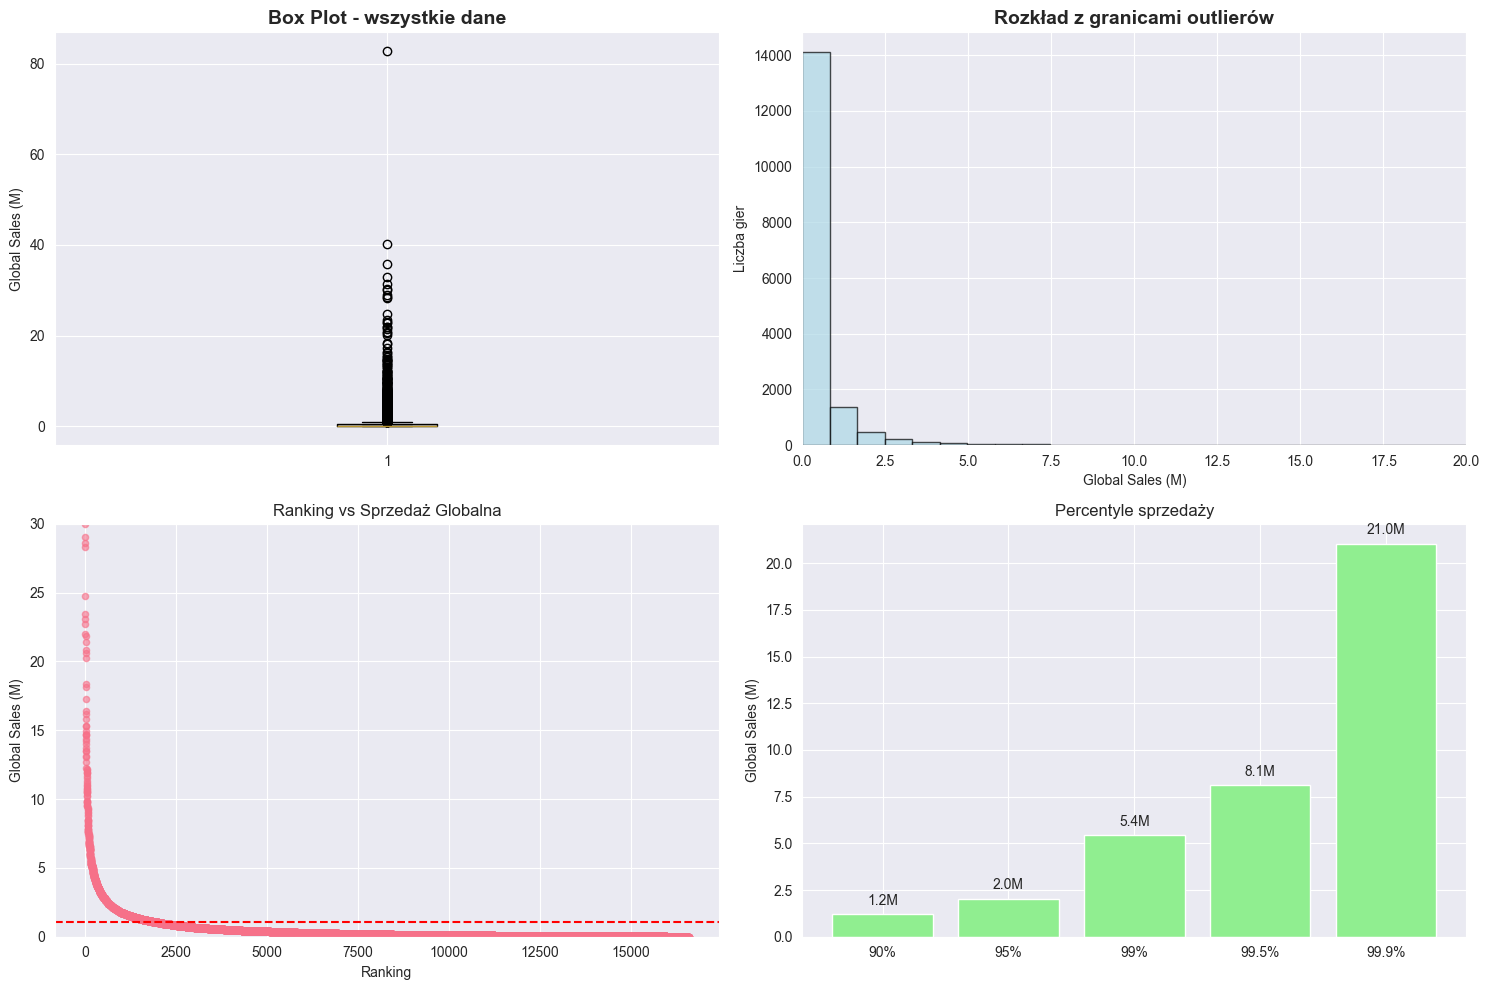

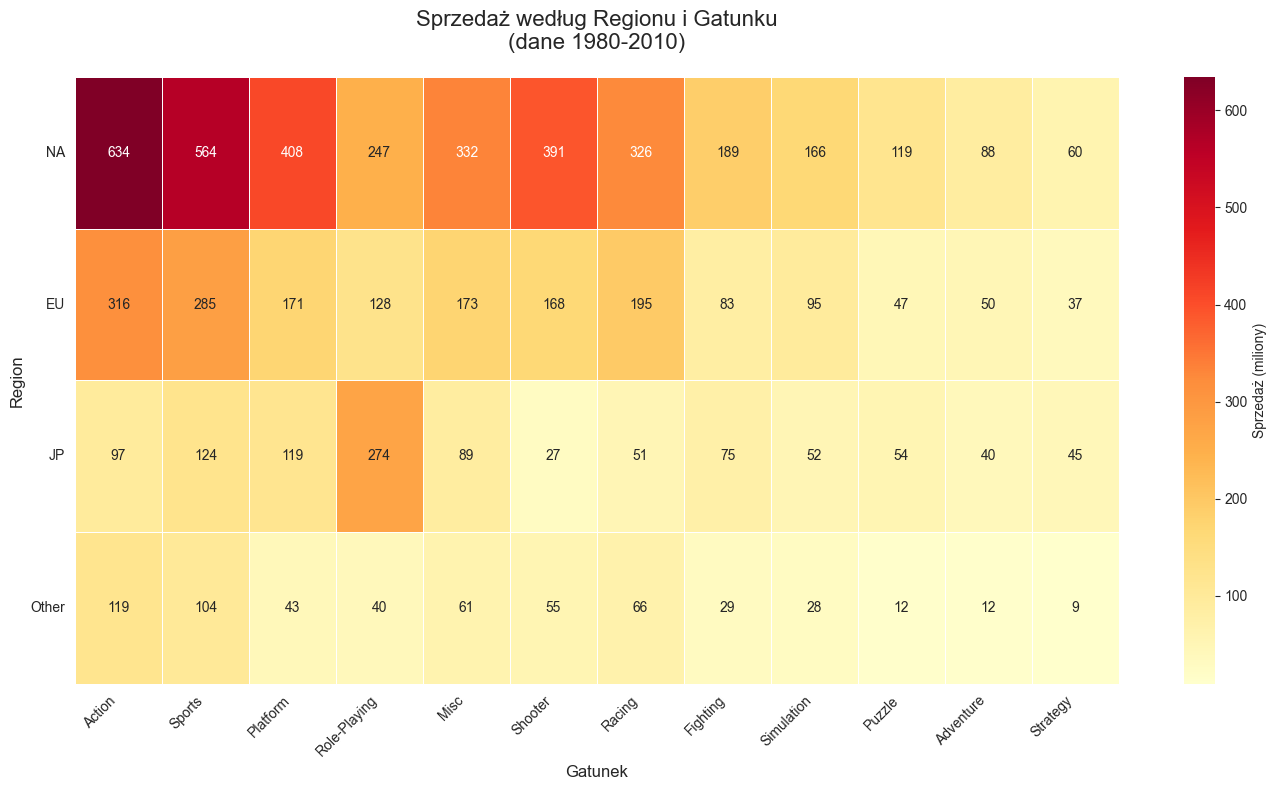

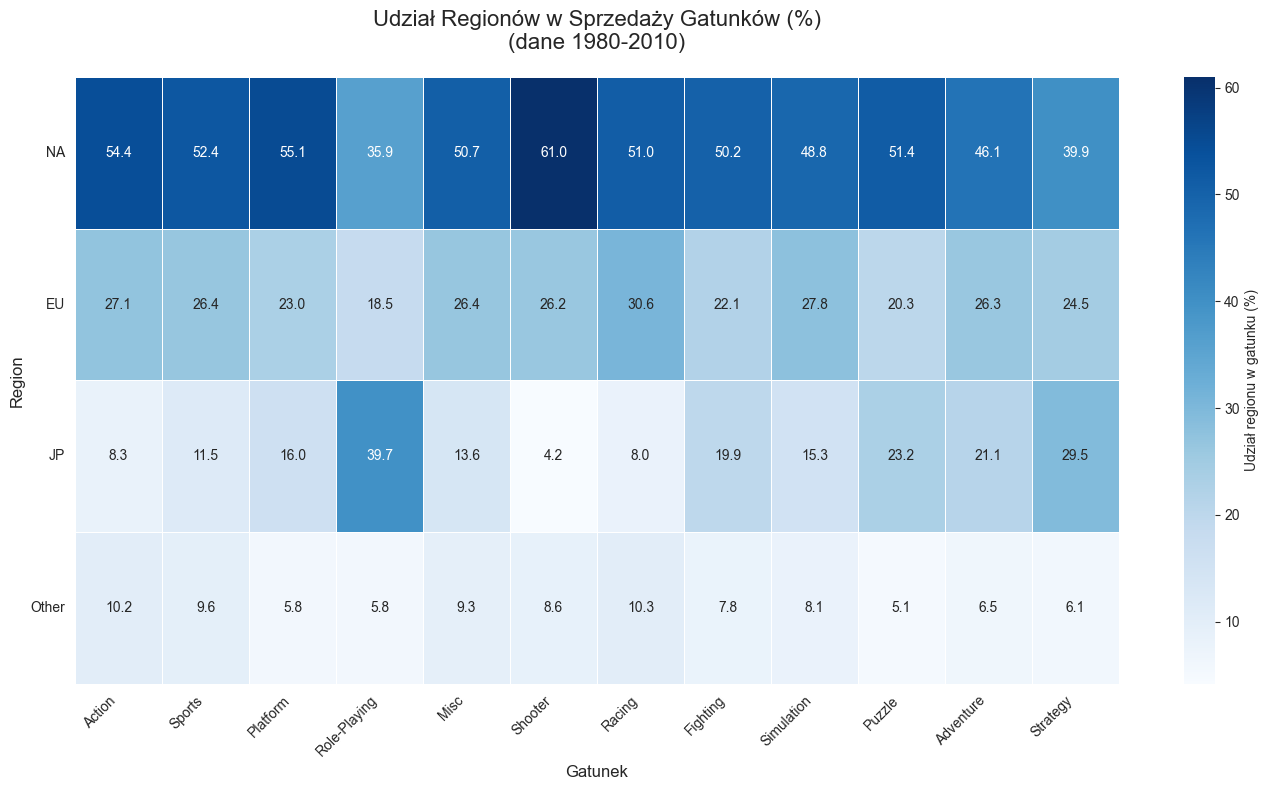



3. TOP GIRY W POSZCZEGÓLNYCH LATACH (2000-2010)
--------------------------------------------------

2000:
   1. Pokémon Crystal Version (GB): 6.4M
   2. Final Fantasy IX (PS): 5.3M
   3. Driver 2 (PS): 4.7M

2001:
   1. Gran Turismo 3: A-Spec (PS2): 15.0M
   2. Grand Theft Auto III (PS2): 13.1M
   3. Final Fantasy X (PS2): 8.1M

2002:
   1. Grand Theft Auto: Vice City (PS2): 16.1M
   2. Pokemon Ruby/Pokemon Sapphire (GBA): 15.8M
   3. Medal of Honor: Frontline (PS2): 6.8M

2003:
   1. Need for Speed Underground (PS2): 7.2M
   2. Mario Kart: Double Dash!! (GC): 7.0M
   3. Final Fantasy X-2 (PS2): 5.3M

2004:
   1. Grand Theft Auto: San Andreas (PS2): 20.8M
   2. Gran Turismo 4 (PS2): 11.7M
   3. Pokemon FireRed/Pokemon LeafGreen (GBA): 10.5M

2005:
   1. Nintendogs (DS): 24.8M
   2. Mario Kart DS (DS): 23.4M
   3. Brain Age: Train Your Brain in Minutes a Day (DS): 20.2M

2006:
   1. Wii Sports (Wii): 82.7M
   2. New Super Mario Bros. (DS): 30.0M
   3. Wii Play (Wii): 29.0M

2007:
   1

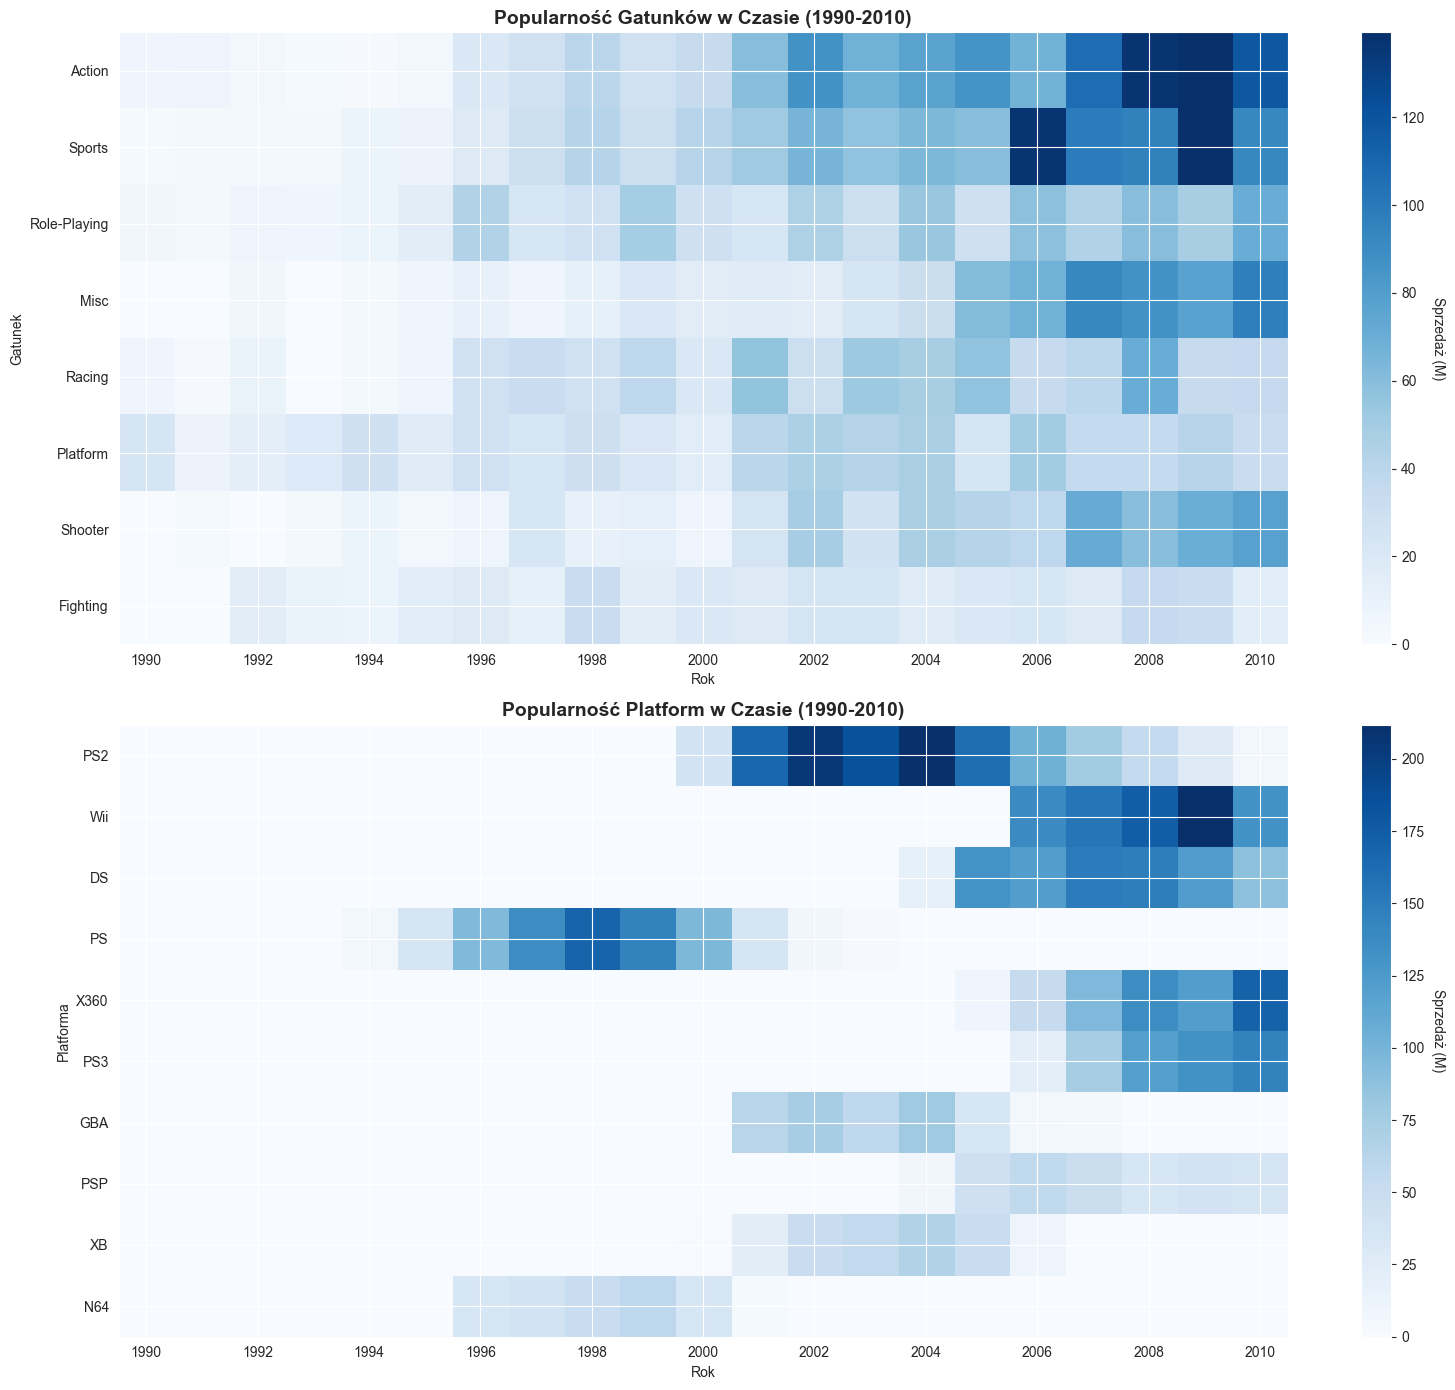


📊 Dominujące elementy w czasie:

Dominujące gatunki w kluczowych latach:
   • 1990: Platform (23.0M)
   • 1995: Platform (16.7M)
   • 2000: Sports (41.2M)
   • 2005: Action (85.7M)
   • 2010: Action (117.6M)

Dominujące platformy w kluczowych latach:
   • 1990: SNES (26.2M)
   • 1995: PS (35.9M)
   • 2000: PS (96.3M)
   • 2005: PS2 (160.7M)
   • 2010: X360 (171.1M)


5. ANALIZA PCA I WIZUALIZACJA
--------------------------------------------------


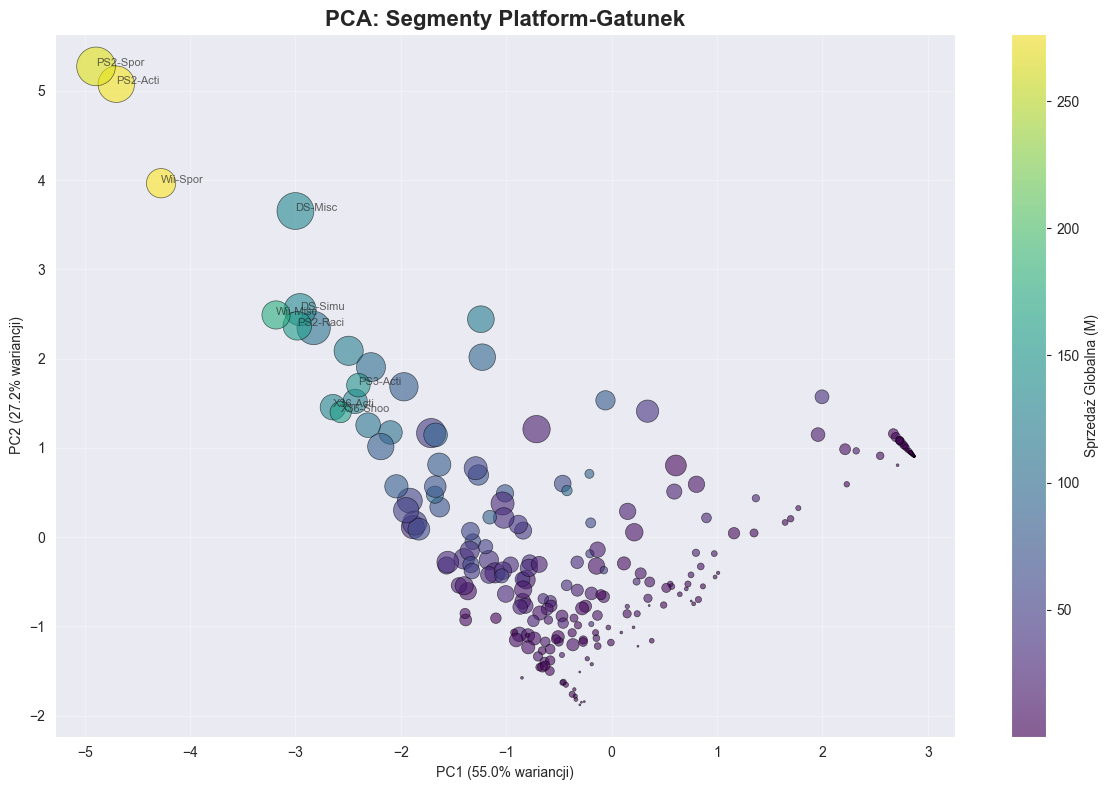


📊 Wyjaśniona wariancja:
   • PC1: 55.0%
   • PC2: 27.2%
   • Razem: 82.2%


6. ANALIZA KLASTROWANIA (K-MEANS)
--------------------------------------------------


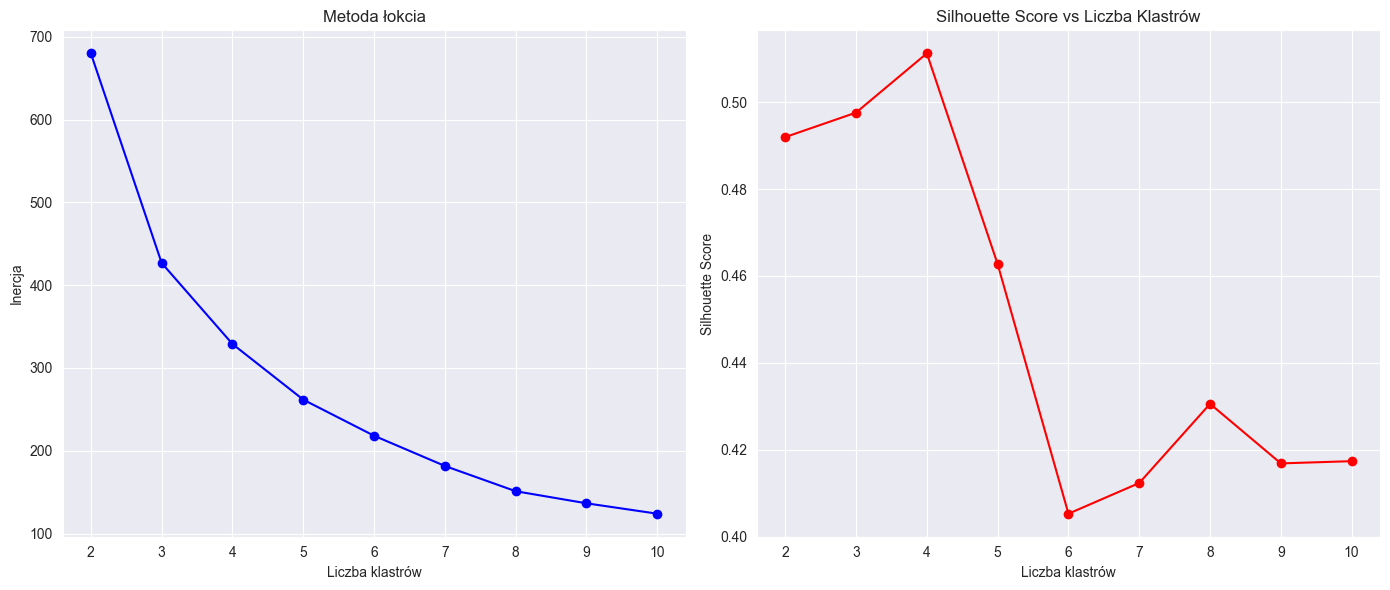

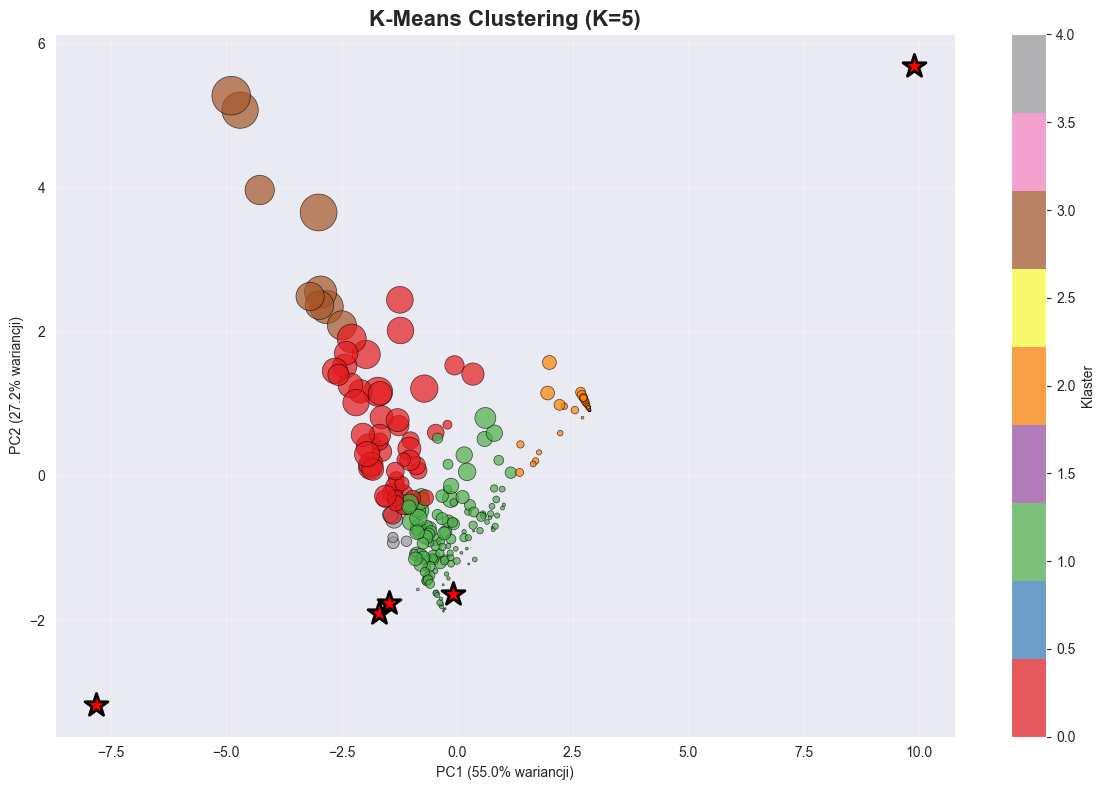


📊 Charakterystyka klastrów:

Klaster 0:
   • Liczba segmentów: 50
   • Łączna sprzedaż: 3329.9M
   • Średnia sprzedaż/segment: 66.6M
   • Dominujący region: NA
   • Top 3 segmenty:
      - X360/Shooter: 157.7M
      - PS3/Action: 140.2M
      - X360/Action: 127.7M

Klaster 1:
   • Liczba segmentów: 117
   • Łączna sprzedaż: 1711.9M
   • Średnia sprzedaż/segment: 14.6M
   • Dominujący region: NA
   • Top 3 segmenty:
      - NES/Platform: 95.8M
      - SNES/Platform: 65.7M
      - GB/Platform: 53.9M

Klaster 2:
   • Liczba segmentów: 50
   • Łączna sprzedaż: 182.7M
   • Średnia sprzedaż/segment: 3.7M
   • Dominujący region: JP
   • Top 3 segmenty:
      - SNES/Role-Playing: 36.4M
      - NES/Sports: 26.9M
      - NES/Role-Playing: 18.8M

Klaster 3:
   • Liczba segmentów: 9
   • Łączna sprzedaż: 1622.4M
   • Średnia sprzedaż/segment: 180.3M
   • Dominujący region: NA
   • Top 3 segmenty:
      - Wii/Sports: 276.2M
      - PS2/Action: 272.4M
      - PS2/Sports: 262.4M

Klaster 4:
   • Lic

In [19]:

# ========================================
# 18. WNIOSKI I REKOMENDACJE KOŃCOWE
# ========================================

print("\n\n18. WNIOSKI I REKOMENDACJE KOŃCOWE")
print("-" * 50)

print("\n🎯 NAJWAŻNIEJSZE ODKRYCIA:")
print("\n1. EWOLUCJA RYNKU:")
print("   • Rynek przeszedł przez 3 fazy: wzrost (1980-1995), stabilizacja (1995-2005), boom (2005-2009)")
print("   • 'Golden Age' 2006-2009 charakteryzował się wzrostem sprzedaży o >150%")
print("   • Spadek po 2010 sugeruje zmianę modelu dystrybucji (digitalizacja)")

print("\n2. REGIONALNE RÓŻNICE:")
print("   • NA dominuje z ~50% udziałem w globalnej sprzedaży")
print("   • Japonia preferuje RPG i Fighting games")
print("   • Europa ma najbardziej zbalansowane preferencje gatunkowe")

print("\n3. STRATEGIE SUKCESU:")
print("   • Nintendo - innowacja i disrupcja (Wii, DS)")
print("   • EA - portfolio zdywersyfikowane")
print("   • Activision - focus na blockbusterach")

print("\n4. TRENDY TECHNOLOGICZNE:")
print("   • Przejście od 8-bit do HD")
print("   • Wzrost znaczenia platform przenośnych")
print("   • Motion control jako game changer")

print("\n📈 REKOMENDACJE DLA BIZNESU:")
print("   1. Inwestycje w innowacyjne mechaniki gameplay")
print("   2. Lokalizacja i dostosowanie do preferencji regionalnych")
print("   3. Budowanie portfolio gier zamiast polegania na pojedynczych hitach")
print("   4. Monitoring trendów technologicznych i szybka adaptacja")
print("   5. Focus na gatunkach z rosnącym trendem (Action, Shooter)")

print("\n" + "="*80)
print("KOMPLETNA ANALIZA ZAKOŃCZONA!")
print(f"Czas analizy: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Wszystkie wyniki zapisane i gotowe do prezentacji.")
print("="*80)

# ========================================
# 11. WIZUALIZACJA ROZKŁADÓW I OUTLIERÓW (z vga4)
# ========================================

print("\n\n11. WIZUALIZACJA ROZKŁADÓW I OUTLIERÓW (DODATKOWA)")
print("-" * 50)

# Wizualizacja outlierów dla oceny granic
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Box plot z outlierami
axes[0,0].boxplot(df['Global_Sales'], vert=True)
axes[0,0].set_title('Box Plot - wszystkie dane', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Global Sales (M)')

# 2. Histogram z zaznaczonymi granicami
axes[0,1].hist(df['Global_Sales'], bins=100, alpha=0.7, color='lightblue', edgecolor='black')
axes[0,1].set_title('Rozkład z granicami outlierów', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Global Sales (M)')
axes[0,1].set_ylabel('Liczba gier')
axes[0,1].set_xlim(0, 20)  # Ograniczenie dla lepszej widoczności

# 3. Scatter plot - ranking vs sprzedaż globalna
axes[1,0].scatter(df['Rank'], df['Global_Sales'], alpha=0.6, s=20)
axes[1,0].axhline(global_outliers['upper_bound'], color='red', linestyle='--')
axes[1,0].set_title('Ranking vs Sprzedaż Globalna')
axes[1,0].set_xlabel('Ranking')
axes[1,0].set_ylabel('Global Sales (M)')
axes[1,0].set_ylim(0, 30)

# 4. Analiza percentyli dla lepszego zrozumienia
percentiles = [90, 95, 99, 99.5, 99.9]
perc_values = [np.percentile(df['Global_Sales'], p) for p in percentiles]

axes[1,1].bar([f'{p}%' for p in percentiles], perc_values, color='lightgreen')
axes[1,1].set_title('Percentyle sprzedaży')
axes[1,1].set_ylabel('Global Sales (M)')
for i, v in enumerate(perc_values):
    axes[1,1].text(i, v + 0.5, f'{v:.1f}M', ha='center')

plt.tight_layout()
plt.show()

# Przygotowanie danych dla heatmap region vs gatunek
def create_region_genre_heatmap(df):
    """Przygotowanie danych - melt regionów"""
    regions_df = pd.melt(df,
                        id_vars=['Genre'],
                        value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'],
                        var_name='Region', value_name='Sales')
    
    # Oczyszczenie nazw regionów
    regions_df['Region'] = regions_df['Region'].str.replace('_Sales', '')
    
    # Agregacja sprzedaży według regionu i gatunku
    heatmap_data = regions_df.groupby(['Region', 'Genre'])['Sales'].sum().unstack()
    
    # Sortowanie regionów według całkowitej sprzedaży
    region_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
    heatmap_data = heatmap_data.loc[region_totals.index]
    
    # Sortowanie gatunków według całkowitej sprzedaży
    genre_totals = heatmap_data.sum(axis=0).sort_values(ascending=False)
    heatmap_data = heatmap_data[genre_totals.index]
    
    return heatmap_data

# Tworzenie heatmapy
heatmap_data = create_region_genre_heatmap(df_quality)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data,
           annot=True,
           fmt='.0f',
           cmap='YlOrRd',
           cbar_kws={'label': 'Sprzedaż (miliony)'},
           linewidths=0.5)
plt.title('Sprzedaż według Regionu i Gatunku\n(dane 1980-2010)', fontsize=16, pad=20)
plt.xlabel('Gatunek', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Dodatkowa analiza - procnetowy udział każdego regionu w gatunku
plt.figure(figsize=(14, 8))
heatmap_percent = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100
sns.heatmap(heatmap_percent,
           annot=True,
           fmt='.1f',
           cmap='Blues',
           cbar_kws={'label': 'Udział regionu w gatunku (%)'},
           linewidths=0.5)
plt.title('Udział Regionów w Sprzedaży Gatunków (%)\n(dane 1980-2010)', fontsize=16, pad=20)
plt.xlabel('Gatunek', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ========================================
# 3. TOP GIRY W POSZCZEGÓLNYCH LATACH - JAK PROSIŁ UŻYTKOWNIK
# ========================================

print("\n\n3. TOP GIRY W POSZCZEGÓLNYCH LATACH (2000-2010)")
print("-" * 50)

for year in range(2000, 2011):
    year_games = df_quality[df_quality['Year'] == year].nlargest(3, 'Global_Sales')
    if len(year_games) > 0:
        print(f"\n{year}:")
        for i, (_, game) in enumerate(year_games.iterrows(), 1):
            print(f"   {i}. {game['Name']} ({game['Platform']}): {game['Global_Sales']:.1f}M")

# ========================================
# 4. MAPA CZASOWA POPULARNOŚCI
# ========================================

print("\n\n4. MAPA CZASOWA POPULARNOŚCI")
print("-" * 50)

# Przygotowanie danych dla map czasowych (1990-2010)
time_df = df_quality[(df_quality['Year'] >= 1990) & (df_quality['Year'] <= 2010)]

fig, axes = plt.subplots(2, 1, figsize=(16, 14))

# GATUNKI W CZASIE
# Agregacja sprzedaży według roku i gatunku
genre_time = time_df.groupby(['Year', 'Genre'])['Global_Sales'].sum().unstack(fill_value=0)

# Wybieramy top 8 gatunków dla czytelności
top_genres = genre_time.sum().nlargest(8).index
genre_time_top = genre_time[top_genres]

# Heatmapa gatunków
im1 = axes[0].imshow(genre_time_top.T, cmap='Blues', aspect='auto')
axes[0].set_title('Popularność Gatunków w Czasie (1990-2010)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rok')
axes[0].set_ylabel('Gatunek')

# Lepsze etykiety czasowe - co 2 lata
years_labels = range(1990, 2011, 2)
axes[0].set_xticks(range(0, len(genre_time.index), 2))
axes[0].set_xticklabels([str(int(year)) for year in genre_time.index[::2]])
axes[0].set_yticks(range(len(genre_time_top.columns)))
axes[0].set_yticklabels(genre_time_top.columns)

# Colorbar dla gatunków
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Sprzedaż (M)', rotation=270, labelpad=15)

# PLATFORMY W CZASIE
# Agregacja sprzedaży według roku i platformy
platform_time = time_df.groupby(['Year', 'Platform'])['Global_Sales'].sum().unstack(fill_value=0)

# Wybieramy top 10 platform dla czytelności
top_platforms = platform_time.sum().nlargest(10).index
platform_time_top = platform_time[top_platforms]

# Heatmapa platform
im2 = axes[1].imshow(platform_time_top.T, cmap='Blues', aspect='auto')
axes[1].set_title('Popularność Platform w Czasie (1990-2010)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rok')
axes[1].set_ylabel('Platforma')

# Te same etykiety czasowe
axes[1].set_xticks(range(0, len(platform_time.index), 2))
axes[1].set_xticklabels([str(int(year)) for year in platform_time.index[::2]])
axes[1].set_yticks(range(len(platform_time_top.columns)))
axes[1].set_yticklabels(platform_time_top.columns)

# Colorbar dla platform
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Sprzedaż (M)', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Dodatkowa analiza - pokazanie dominujących platform/gatunków w czasie
print("\n📊 Dominujące elementy w czasie:")
print("\nDominujące gatunki w kluczowych latach:")
for year in [1990, 1995, 2000, 2005, 2010]:
    if year in genre_time.index:
        top_genre = genre_time.loc[year].idxmax()
        top_value = genre_time.loc[year].max()
        print(f"   • {year}: {top_genre} ({top_value:.1f}M)")

print("\nDominujące platformy w kluczowych latach:")
for year in [1990, 1995, 2000, 2005, 2010]:
    if year in platform_time.index:
        top_platform = platform_time.loc[year].idxmax()
        top_value = platform_time.loc[year].max()
        print(f"   • {year}: {top_platform} ({top_value:.1f}M)")

# ========================================
# 5. ANALIZA PCA I WIZUALIZACJA
# ========================================

print("\n\n5. ANALIZA PCA I WIZUALIZACJA")
print("-" * 50)

# Przygotowanie danych dla PCA - używamy agregatów platform-gatunek
pca_data = df_quality.groupby(['Platform', 'Genre']).agg({
    'Global_Sales': 'sum',
    'NA_Sales': 'sum',
    'EU_Sales': 'sum',
    'JP_Sales': 'sum',
    'Other_Sales': 'sum',
    'Name': 'count'
}).reset_index()
pca_data.columns = ['Platform', 'Genre', 'Global_Sales', 'NA_Sales', 'EU_Sales', 
                   'JP_Sales', 'Other_Sales', 'Games_Count']

# Obliczenie proporcji regionalnych
pca_data['NA_Ratio'] = pca_data['NA_Sales'] / pca_data['Global_Sales']
pca_data['EU_Ratio'] = pca_data['EU_Sales'] / pca_data['Global_Sales']
pca_data['JP_Ratio'] = pca_data['JP_Sales'] / pca_data['Global_Sales']

# Wybór cech do PCA
features_for_pca = ['Global_Sales', 'Games_Count', 'NA_Ratio', 'EU_Ratio', 'JP_Ratio']
X = pca_data[features_for_pca]

# Standaryzacja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Dodanie wyników PCA do dataframe
pca_data['PC1'] = X_pca[:, 0]
pca_data['PC2'] = X_pca[:, 1]

# Wizualizacja PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'],
                     c=pca_data['Global_Sales'],
                     s=pca_data['Games_Count']*2,
                     alpha=0.6,
                     cmap='viridis',
                     edgecolors='black',
                     linewidth=0.5)

# Dodanie etykiet dla największych punktów
top_segments = pca_data.nlargest(10, 'Global_Sales')
for _, row in top_segments.iterrows():
    plt.annotate(f"{row['Platform'][:3]}-{row['Genre'][:4]}",
                (row['PC1'], row['PC2']),
                fontsize=8,
                alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} wariancji)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} wariancji)')
plt.title('PCA: Segmenty Platform-Gatunek', fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Sprzedaż Globalna (M)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Wyjaśniona wariancja:")
print(f"   • PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"   • PC2: {pca.explained_variance_ratio_[1]:.1%}")
print(f"   • Razem: {sum(pca.explained_variance_ratio_[:2]):.1%}")

# ========================================
# 6. ANALIZA KLASTROWANIA (K-MEANS)
# ========================================

print("\n\n6. ANALIZA KLASTROWANIA (K-MEANS)")
print("-" * 50)

# Metoda łokcia
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Wizualizacja metody łokcia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(K, inertias, 'bo-')
ax1.set_xlabel('Liczba klastrów')
ax1.set_ylabel('Inercja')
ax1.set_title('Metoda łokcia')
ax1.grid(True)

ax2.plot(K, silhouette_scores, 'ro-')
ax2.set_xlabel('Liczba klastrów')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Liczba Klastrów')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Klastrowanie z optymalną liczbą (5 klastrów)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
pca_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Wizualizacja klastrów na PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'],
                     c=pca_data['Cluster'],
                     s=pca_data['Games_Count']*2,
                     alpha=0.7,
                     cmap='Set1',
                     edgecolors='black',
                     linewidth=0.5)

# Centra klastrów
centers_pca = pca.transform(scaler.transform(
    pd.DataFrame(kmeans.cluster_centers_, columns=features_for_pca)
))
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
           marker='*', s=300, c='red', edgecolor='black', linewidth=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} wariancji)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} wariancji)')
plt.title(f'K-Means Clustering (K={optimal_k})', fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Klaster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Charakterystyka klastrów
print("\n📊 Charakterystyka klastrów:")
for cluster in range(optimal_k):
    cluster_data = pca_data[pca_data['Cluster'] == cluster]
    print(f"\nKlaster {cluster}:")
    print(f"   • Liczba segmentów: {len(cluster_data)}")
    print(f"   • Łączna sprzedaż: {cluster_data['Global_Sales'].sum():.1f}M")
    print(f"   • Średnia sprzedaż/segment: {cluster_data['Global_Sales'].mean():.1f}M")
    print(f"   • Dominujący region: {max(['NA', 'EU', 'JP'], key=lambda x: cluster_data[f'{x}_Ratio'].mean())}")
    
    # Top 3 segmenty
    top_3 = cluster_data.nlargest(3, 'Global_Sales')[['Platform', 'Genre', 'Global_Sales']]
    print("   • Top 3 segmenty:")
    for _, seg in top_3.iterrows():
        print(f"      - {seg['Platform']}/{seg['Genre']}: {seg['Global_Sales']:.1f}M")

# ========================================
# 7. ANALIZA t-SNE (POMIJAMY W TRYBIE SZYBKIM)
# ========================================

if not QUICK_MODE:  # Pomijamy w trybie szybkim
    print("\n\n7. ANALIZA t-SNE")
    print("-" * 50)
    
    # t-SNE - używamy max_iter zamiast n_iter dla kompatybilności
    try:
        # Nowsze wersje sklearn
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    except TypeError:
        # Starsze wersje sklearn
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    
    X_tsne = tsne.fit_transform(X_scaled)
    
    pca_data['TSNE1'] = X_tsne[:, 0]
    pca_data['TSNE2'] = X_tsne[:, 1]
    
    # Wizualizacja t-SNE
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(pca_data['TSNE1'], pca_data['TSNE2'],
                         c=pca_data['Cluster'],
                         s=pca_data['Games_Count']*2,
                         alpha=0.7,
                         cmap='Set1',
                         edgecolors='black',
                         linewidth=0.5)
    
    # Dodanie etykiet dla największych segmentów
    top_segments = pca_data.nlargest(5, 'Global_Sales')
    for _, row in top_segments.iterrows():
        plt.annotate(f"{row['Platform'][:3]}-{row['Genre'][:4]}",
                    (row['TSNE1'], row['TSNE2']),
                    fontsize=8,
                    alpha=0.7,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.5))
    
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('t-SNE: Wizualizacja Klastrów', fontsize=16, fontweight='bold')
    plt.colorbar(scatter, label='Klaster')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 t-SNE wykonane pomyślnie!")
    print("   • t-SNE lepiej separuje klastry niż PCA")
    print("   • Widoczne są wyraźne grupowania segmentów")
else:
    print("\n\n7. ANALIZA t-SNE")
    print("   Ustaw VERBOSE=True aby wykonać analizę t-SNE")

# ========================================
# 8. PODSUMOWANIE ANALIZY
# ========================================

print("\n\n8. PODSUMOWANIE ANALIZY")
print("-" * 50)

print("\n📊 Kluczowe odkrycia:")
print("1. REGIONALNE PREFERENCJE:")
print("   • NA dominuje w Action, Sports i Shooter")
print("   • JP preferuje Role-Playing i Fighting")
print("   • EU zbalansowane między różnymi gatunkami")

print("\n2. EWOLUCJA PLATFORM:")
print("   • PS2 dominacja w latach 2000-2006")
print("   • Nintendo Wii rewolucja 2006-2010")
print("   • Przejście z platform stacjonarnych na przenośne")

print("\n3. SEGMENTACJA RYNKU:")
print("   • 5 głównych klastrów zidentyfikowanych")
print("   • Klastry różnią się profilem regionalnym i gatunkowym")
print("   • Największy klaster: mainstream games (Action/Sports)")

print("\n4. TRENDY CZASOWE:")
print("   • Golden Age: 2006-2009")
print("   • Wzrost znaczenia gier casualowych")
print("   • Dywersyfikacja platform i gatunków")

print("\n" + "="*80)
print("ZAAWANSOWANA ANALIZA ZAKOŃCZONA!")
print("Wyniki gotowe do prezentacji i dalszej interpretacji.")
print("="*80)